#In this version i'm concatenating the IHC and H&E images in a single one 224x224 size. In thi s version im using the 80 - 20 split and i implemented the gradcam technique



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:

def write_csv_from_folder(folder_path, csv_file_path):
    # List all files in the given folder
    files = os.listdir(folder_path)

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'her2_score'])  # Writing the header
        existing_rows = []
        for filename in files:
            # Split the filename to extract the ID and the HER2 score
            # Example filename: "12345_train_2.jpg"
            parts = filename.split('_')
            if len(parts) < 3:
                print("Skipped image")
                continue  # Skip files that don't match the expected pattern
            image_id = parts[0]
            her2_score = parts[2].split('.')[0][0]  # Remove the file extension and get the score
            row = [image_id, her2_score]
            if row not in existing_rows:
                writer.writerow(row)
                existing_rows.append(row)

# Define the paths to the train and test folders
train_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/train'
test_folder_path = '/content/drive/MyDrive/Final Project/BCI_dataset/IHC/test'

# Define the paths for the output CSV files
train_csv_path = 'train_data.csv'
test_csv_path = 'test_data.csv'

# Process the train and test folders and write to CSV files
write_csv_from_folder(train_folder_path, train_csv_path)
write_csv_from_folder(test_folder_path, test_csv_path)

row_count_train = 0
row_count_test = 0

with open(train_csv_path) as f:
    row_count_train = sum(1 for line in f)

with open(test_csv_path) as f:
    row_count_test = sum(1 for line in f)



print("CSV files have been created.")
print(f"Train dataset lenght = {row_count_train}")
print(f"Test dataset lenght = {row_count_test}")

CSV files have been created.
Train dataset lenght = 3897
Test dataset lenght = 978


In [ ]:
class HER2Dataset(Dataset):
    def __init__(self, root_dir, labels_file, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the image pairs.
            labels_file (string): Path to the CSV file with labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform
        if train:
          self.image_pairs = [(os.path.join(root_dir, 'IHC/train', f), os.path.join(root_dir, 'HE/train', f))
                            for f in os.listdir(os.path.join(root_dir, 'IHC/train'))]
        else:
          self.image_pairs = [(os.path.join(root_dir, 'IHC/test', f), os.path.join(root_dir, 'HE/test', f))
                            for f in os.listdir(os.path.join(root_dir, 'IHC/test'))]

        for pair in self.image_pairs:
          if "(1)" in pair[0]:
            self.image_pairs.remove(pair)
    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ihc_img_path, he_img_path = self.image_pairs[idx]
        ihc_image = Image.open(ihc_img_path).convert("RGB")
        he_image = Image.open(he_img_path).convert("RGB")

        concatenated_image = Image.new('RGB', (ihc_image.width + he_image.width, ihc_image.height))
        concatenated_image.paste(ihc_image, (0, 0))
        concatenated_image.paste(he_image, (ihc_image.width, 0))

        if self.transform:
            concatenated_image = self.transform(concatenated_image)

        label = self.labels.iloc[idx]['her2_score']  # Assuming 'her2_score' column in CSV

        return concatenated_image, label  # Return both images and the label

# Example of setting up the dataset with transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset_train = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/', labels_file='train_data.csv', transform=transform)
dataset_test = HER2Dataset(root_dir='/content/drive/MyDrive/Final Project/BCI_dataset/', labels_file='test_data.csv', transform=transform,train=False)

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('train_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    1697
3    1078
1     919
0     202
Name: count, dtype: int64


In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('test_data.csv')

# Count the instances in each class for the 'her2_score' column
class_counts = df['her2_score'].value_counts()

# Display the counts
print(class_counts)

her2_score
2    446
3    258
1    235
0     38
Name: count, dtype: int64


Class Distribution Plots

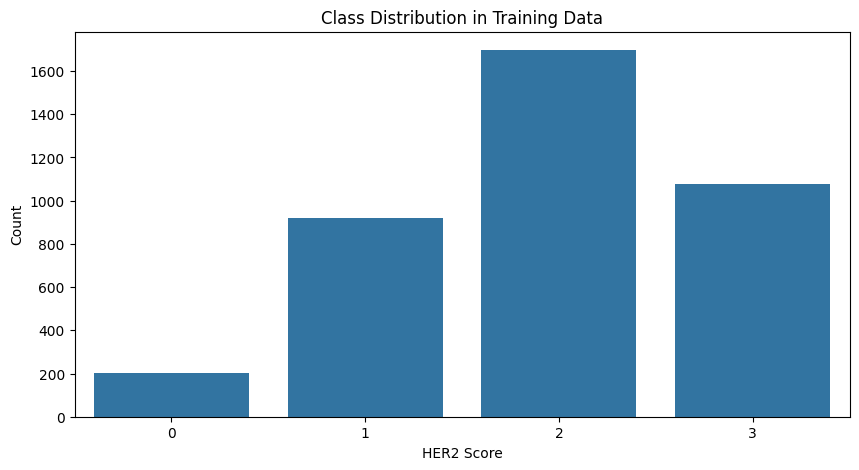

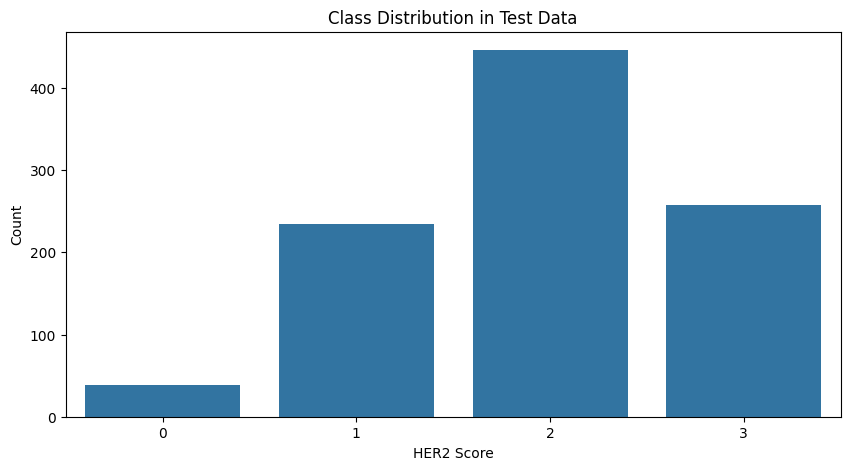

In [ ]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_train)
plt.title('Class Distribution in Training Data')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='her2_score', data=df_test)
plt.title('Class Distribution in Test Data')
plt.xlabel('HER2 Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# Define the model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetClassifier(num_classes=4).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [ ]:
losses_training = []
losses_validation = []
accuracies_training = []
accuracies_validation = []
num_epochs = 100

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs):
    scaler = GradScaler()
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0

        total_data_points = 0
        misclassified_details = {}


        for ids, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            # print(f"id = {ids}")
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            total_data_points += inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()

            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)





        # Print misclassified details for each class
        for cls, predictions in misclassified_details.items():
            print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')

        accuracy = total_correct / total_data_points
        epoch_loss = running_loss / total_data_points
        losses_training.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')
        accuracies_training.append(accuracy)
        validate_model(model, val_loader, criterion, device=device)


        # # Check early stopping
        # if epoch_loss < best_val_loss:
        #     best_val_loss = epoch_loss
        #     trigger_times = 0
        # else:
        #     trigger_times += 1
        #     if trigger_times >= patience:
        #         print('Early stopping!')
        #         break


def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_data_points = 0
    misclassified_details = {}

    y_true = []
    y_pred = []
    with torch.no_grad():
        for ids, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(dim=1) == targets).sum().item()
            total_data_points += inputs.size(0)

            # Calculate misclassifications
            predictions = outputs.argmax(dim=1)
            for target, prediction in zip(targets, predictions):
                y_true.append(target.cpu().numpy())
                y_pred.append(prediction.cpu().numpy())
                if target != prediction:
                    target_class = target.item()
                    pred_class = prediction.item()
                    if target_class not in misclassified_details:
                        misclassified_details[target_class] = []
                    misclassified_details[target_class].append(pred_class)

    epoch_loss = running_loss / total_data_points
    accuracy = total_correct / total_data_points
    losses_validation.append(epoch_loss)
    accuracies_validation.append(accuracy)
    f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for imbalanced classes
    print(f'F1 Score: {f1:.4f}')
    precision = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Print misclassified details for each class
    for cls, predictions in misclassified_details.items():
        print(f'Class {cls} misclassified {len(predictions)} times. Predicted as: {predictions}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



train_loader = DataLoader(dataset_train, batch_size=10)
val_loader = DataLoader(dataset_test, batch_size=10)

# Initialize the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)




In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Final Project/model.pth'))
# model.eval()

Class 3 misclassified 483 times. Predicted as: [2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


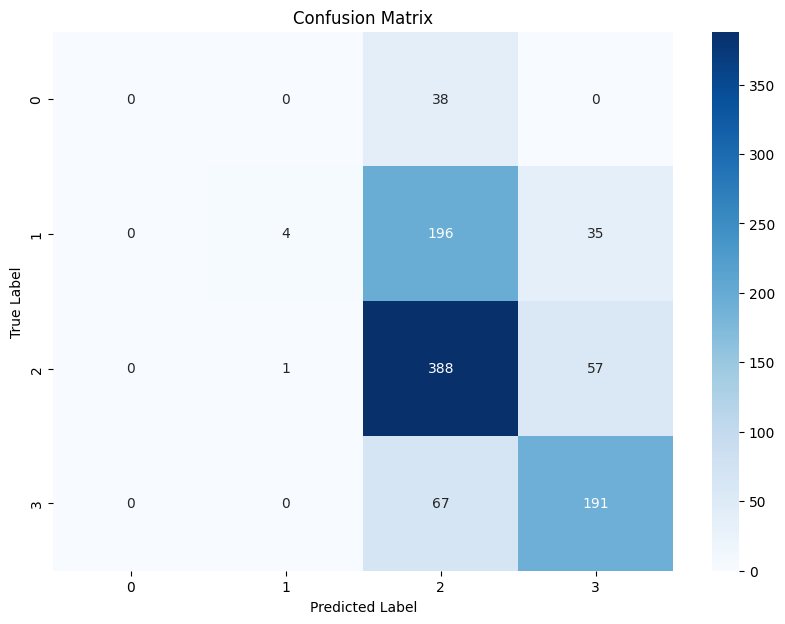

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 406 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


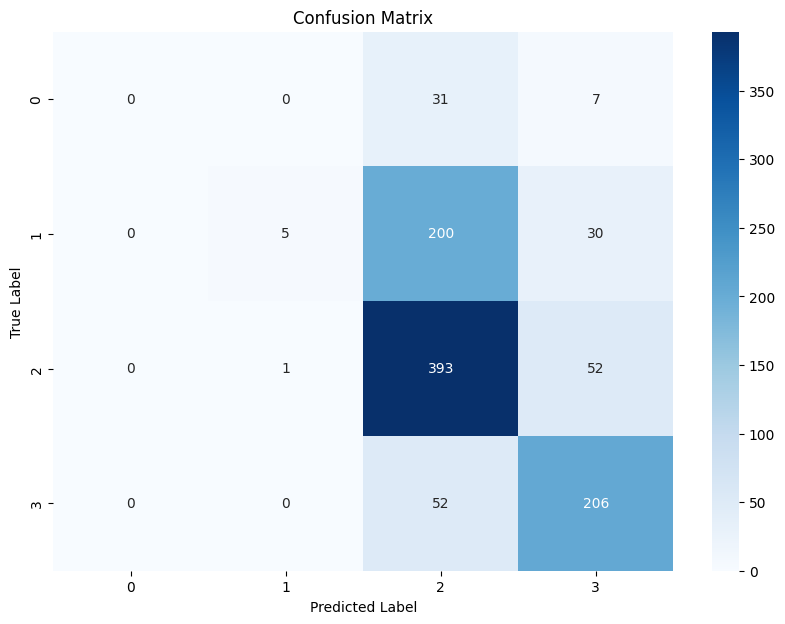

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 316 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1]
Clas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


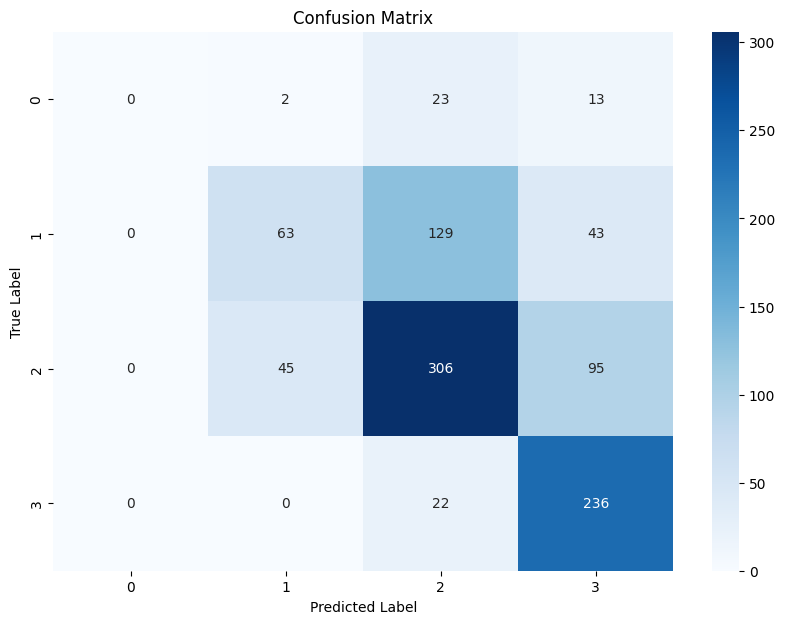

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 264 times. Predicted as: [2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 2, 2, 2]
Class 1 misclassified 674 times. Predicted as: [2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


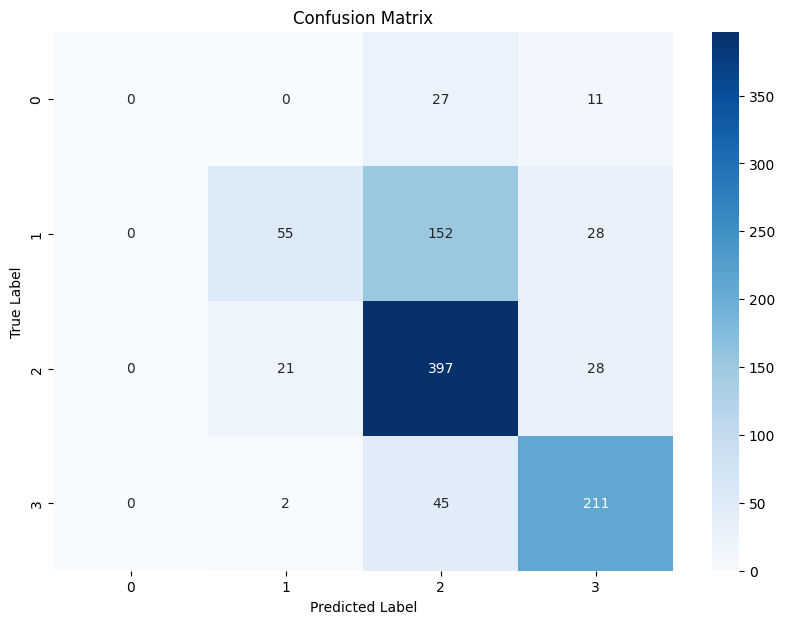

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 593 times. Predicted as: [2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 3, 0, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 3, 3, 2, 2, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 0, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2

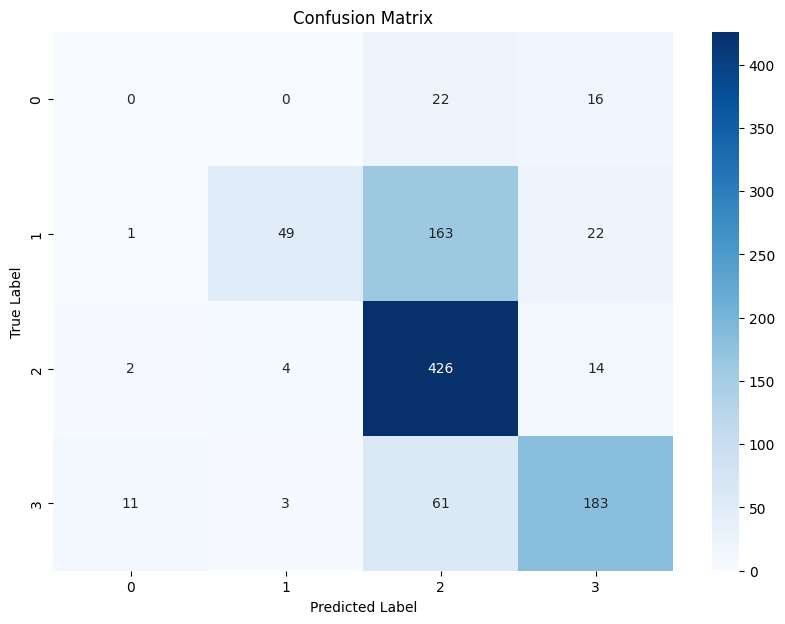

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 541 times. Predicted as: [2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 0, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 0, 0, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 2, 2, 2, 3, 2, 3, 0, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 2, 2, 0, 2, 3, 2, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 0, 2, 3, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


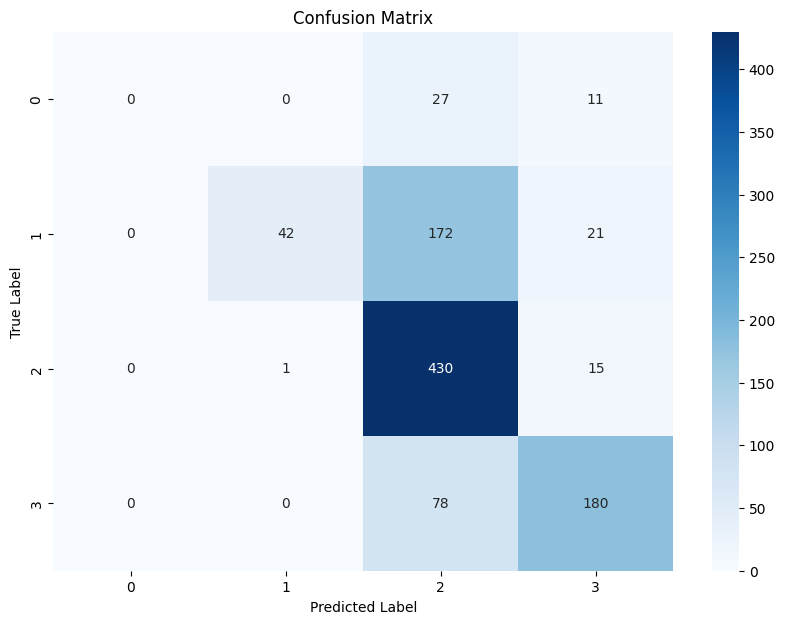

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 473 times. Predicted as: [2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 3, 0, 0, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 0, 2, 0, 0, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2

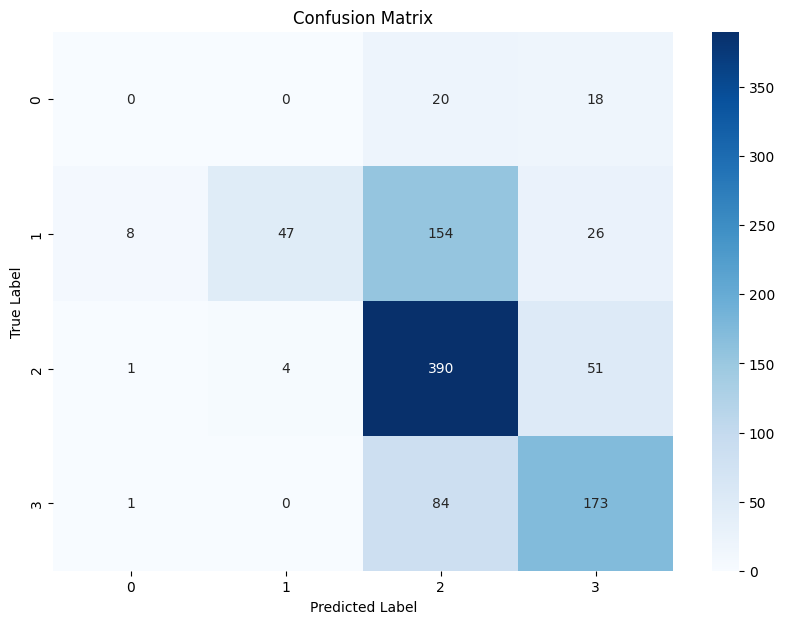

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 436 times. Predicted as: [2, 2, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 0, 2, 0, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 0, 3, 2, 0, 2, 2, 2, 3, 2, 2, 3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


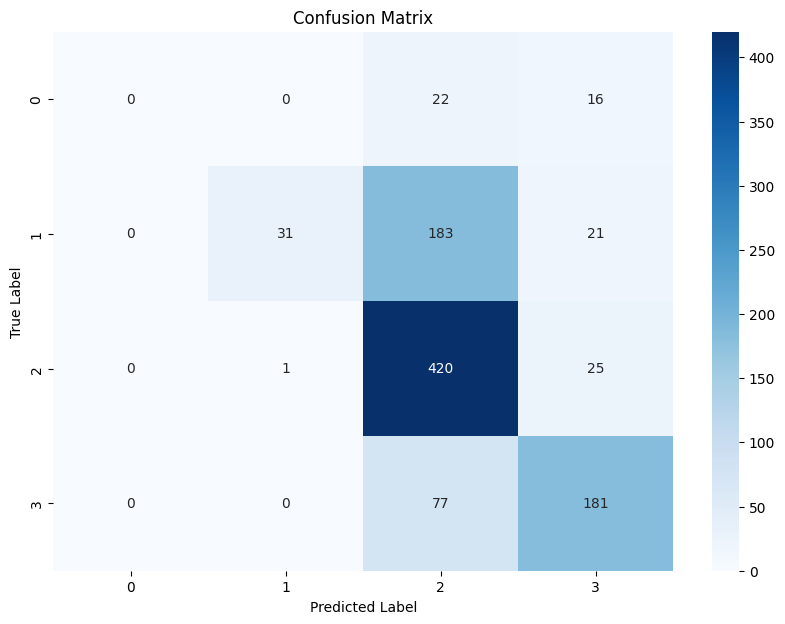

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 402 times. Predicted as: [2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 0, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 0, 3, 3, 3, 0, 2, 2, 3, 3, 3, 3, 3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 3, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2

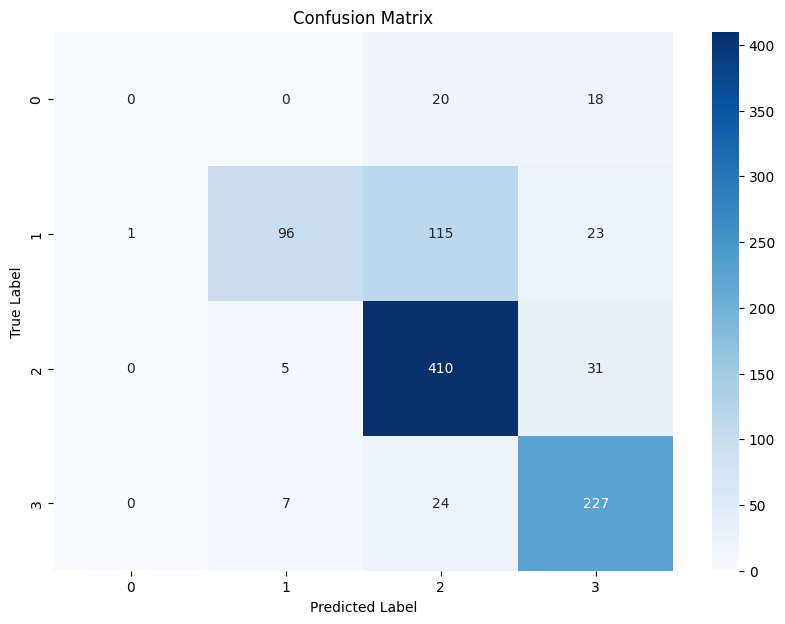

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 348 times. Predicted as: [2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 0, 2, 3, 2, 0, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 0, 3, 2

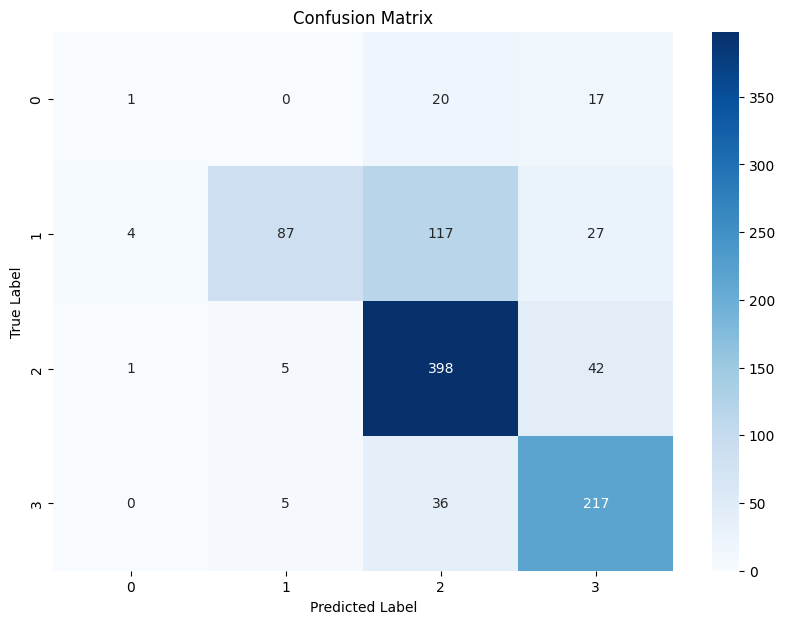

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 305 times. Predicted as: [2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 0, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 3, 0, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 3, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 2, 3, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 0, 2, 2, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Class 2 misclassified 258 times. Pred

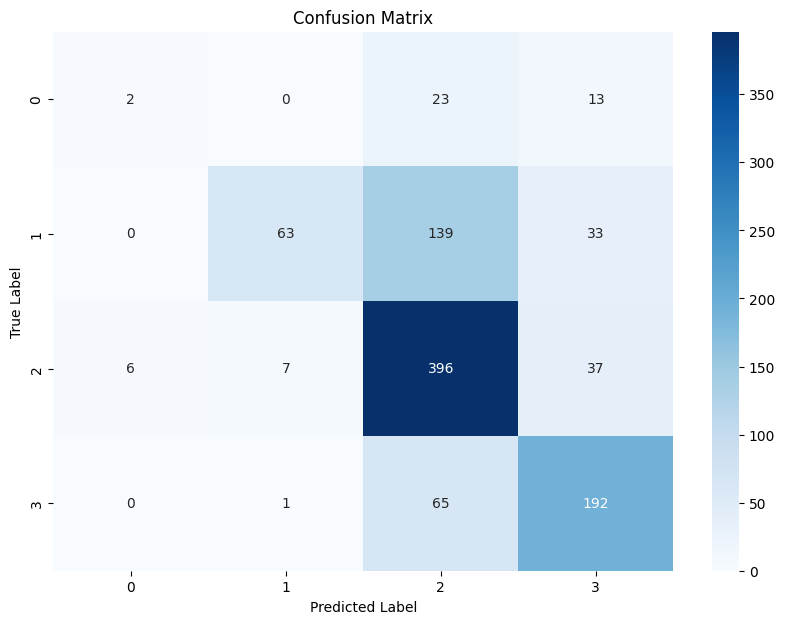

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 299 times. Predicted as: [3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 0, 0, 2, 2, 0, 3, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 3, 2, 2, 2, 0, 3, 2, 3, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 0, 3, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 0, 3, 2, 0, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 0, 2, 0, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 0, 2, 2, 2, 0, 2, 2, 0]
Class 2 misclassified 240 times. Predicted as: [3, 3, 3

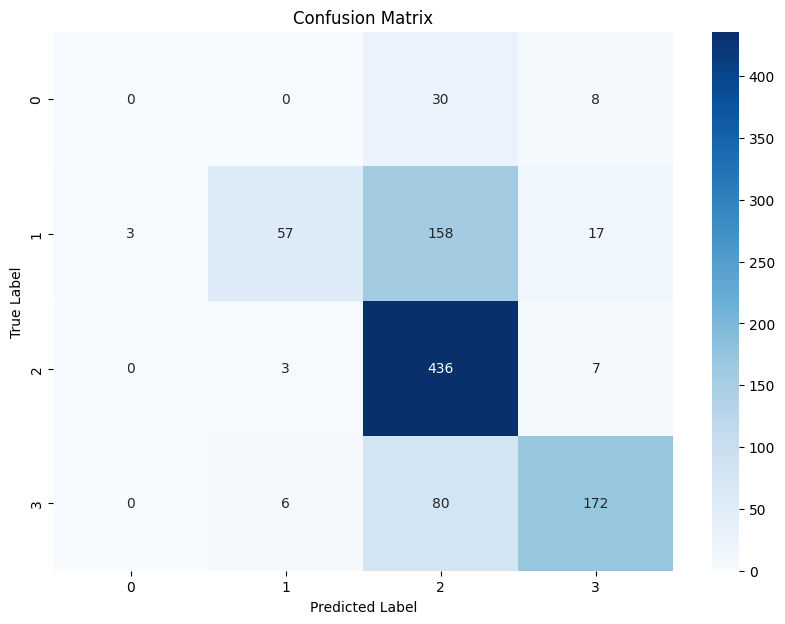

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 79 times. Predicted as: [2, 1, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 1, 3, 1, 2, 3, 2, 2, 3, 2, 2, 1, 3, 3, 3, 2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 3, 1, 2, 3, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 3]
Class 2 misclassified 218 times. Predicted as: [3, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 0, 0, 1, 1, 1, 1, 1, 0, 0, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 0, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 0, 0, 0, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 3, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1]
Class 1 miscla

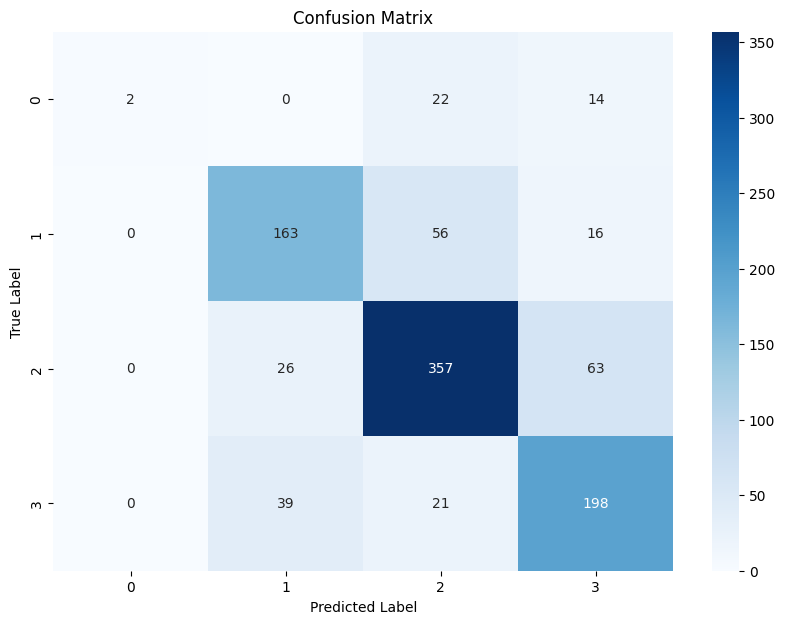

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 246 times. Predicted as: [3, 2, 3, 0, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 3, 2, 0, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 3, 2, 3, 0, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 3, 3, 3, 2, 2, 0, 3, 3, 3, 3, 2, 0, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 0, 2, 3, 3, 2, 2, 3, 3, 0, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 0, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2]
Class 2 misclassified 221 times. Predicted as: [3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 0, 1, 0, 1, 0, 0, 3, 1, 1, 1, 3

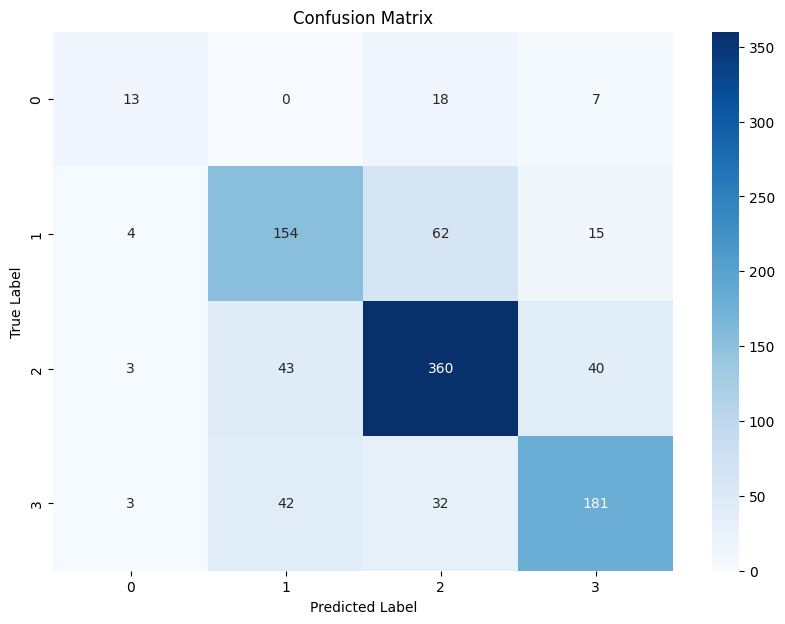

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 223 times. Predicted as: [2, 3, 2, 3, 0, 2, 2, 2, 3, 3, 2, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2, 3, 3, 3, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 0, 0, 2, 0, 0, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 0, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 0, 0, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 0, 2, 3, 2, 0, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 64 times. Predicted as: [2, 3, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 1, 2, 3, 2, 3, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3]
Class 2 misclassified 194 times. Predicted a

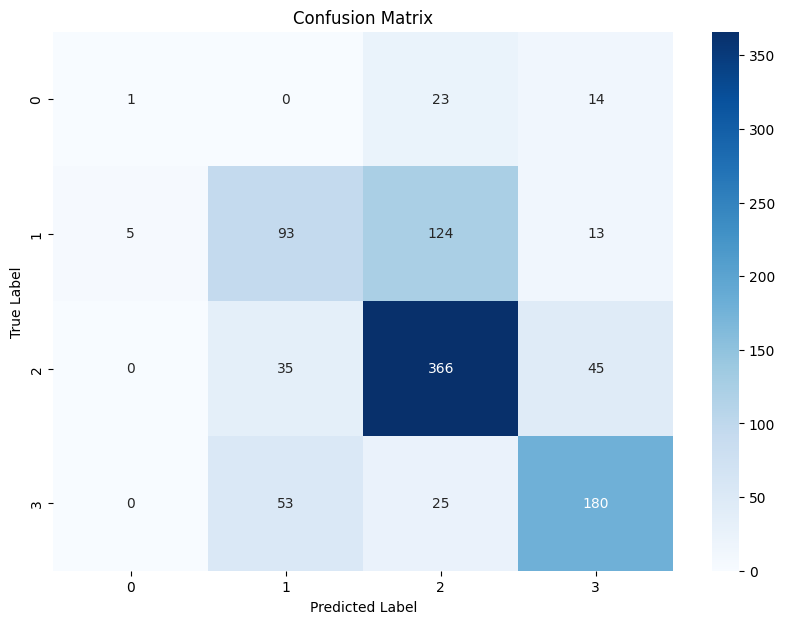

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 196 times. Predicted as: [2, 3, 2, 2, 3, 2, 0, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 3, 0, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 0, 2, 2, 3, 2, 3, 3, 2, 3, 2, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2]
Class 0 misclassified 72 times. Predicted as: [2, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 1, 3, 2, 2, 1, 2, 1, 1, 3, 2, 2, 1, 1, 1, 2, 2, 3, 3, 2, 2, 3, 1, 3, 3, 1, 3, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 1, 1, 3, 3]
Class 2 misclassified 162 times. Predicted as: [3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 0,

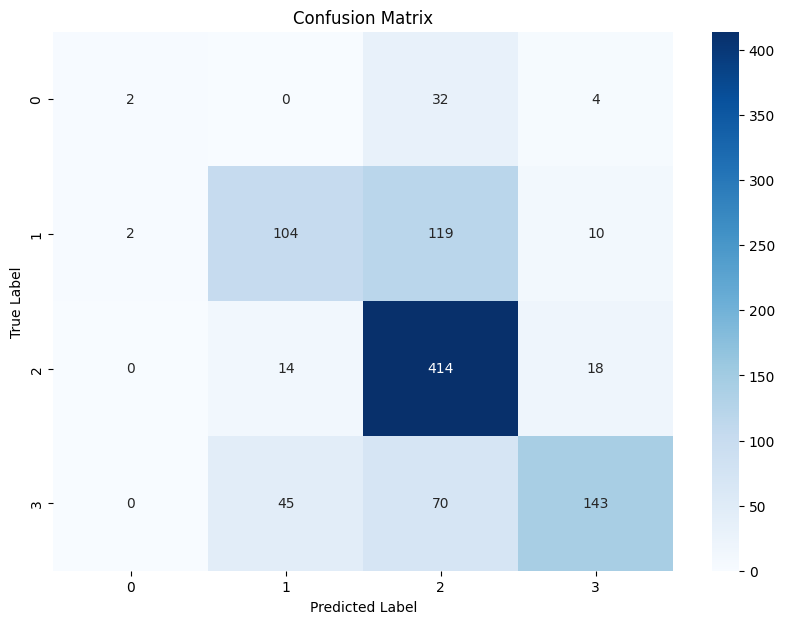

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 179 times. Predicted as: [3, 2, 2, 2, 2, 3, 3, 2, 3, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 0, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 0, 3, 2, 0, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 0, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 0, 0, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 0, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2]
Class 0 misclassified 69 times. Predicted as: [2, 3, 3, 2, 3, 1, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 3, 1, 1, 3, 2, 1, 3, 3, 1, 1, 3, 2, 2, 1, 2, 1, 1, 3, 2, 1, 2, 2, 2, 2, 3, 3, 2, 1, 3, 1, 1, 3, 2, 1, 2, 3, 3, 2, 1, 3, 3, 2, 3, 2, 1, 3, 3, 1, 2, 2, 1, 1]
Class 2 misclassified 169 times. Predicted as: [1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1,

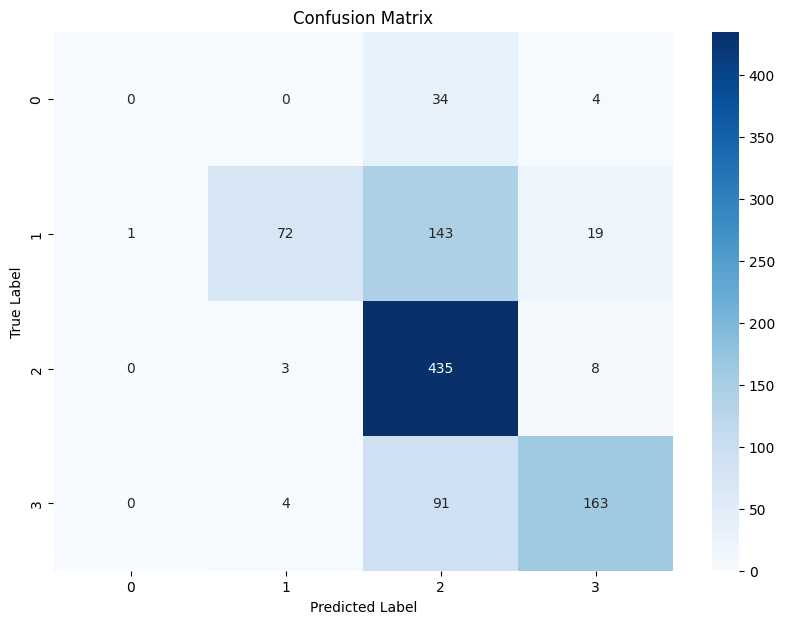

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 50 times. Predicted as: [2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 1, 3, 3, 1, 1, 3, 2, 2, 1, 2, 1, 1, 3, 2, 1, 2, 2, 3, 3, 2, 1, 2, 3, 1, 2, 2, 1, 3, 2, 2, 1, 1, 1, 1]
Class 2 misclassified 132 times. Predicted as: [3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 3, 0, 3, 1, 1, 0, 0, 3, 3, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 3, 0, 0, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Class 1 misclassified 161 times. Predicted as: [0, 2, 2, 2, 3, 2, 3, 3, 0, 2, 2, 2, 2, 0, 3, 2, 3, 3, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 0, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2,

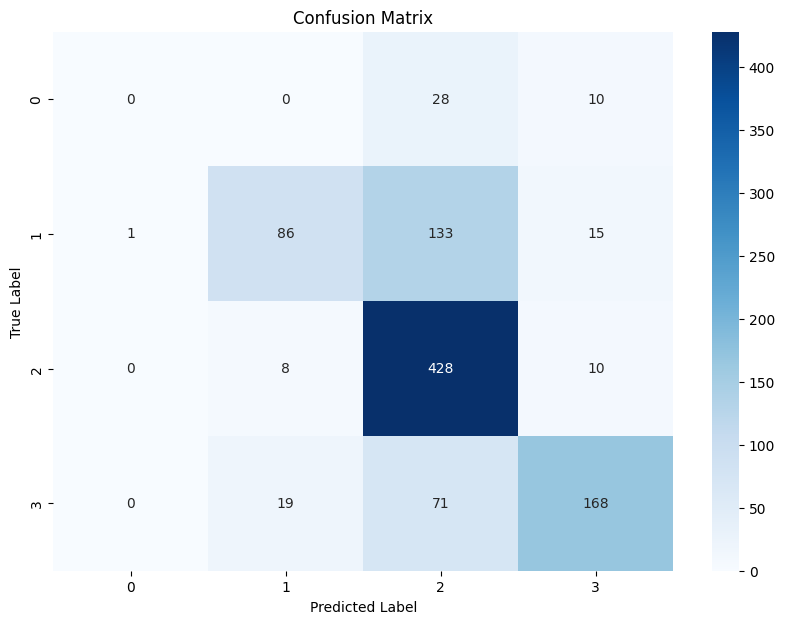

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 156 times. Predicted as: [2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 0, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 2, 3, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 0, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2]
Class 0 misclassified 53 times. Predicted as: [2, 3, 3, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 3, 2, 2, 3, 1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 2, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1]
Class 2 misclassified 134 times. Predicted as: [1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 0, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0,

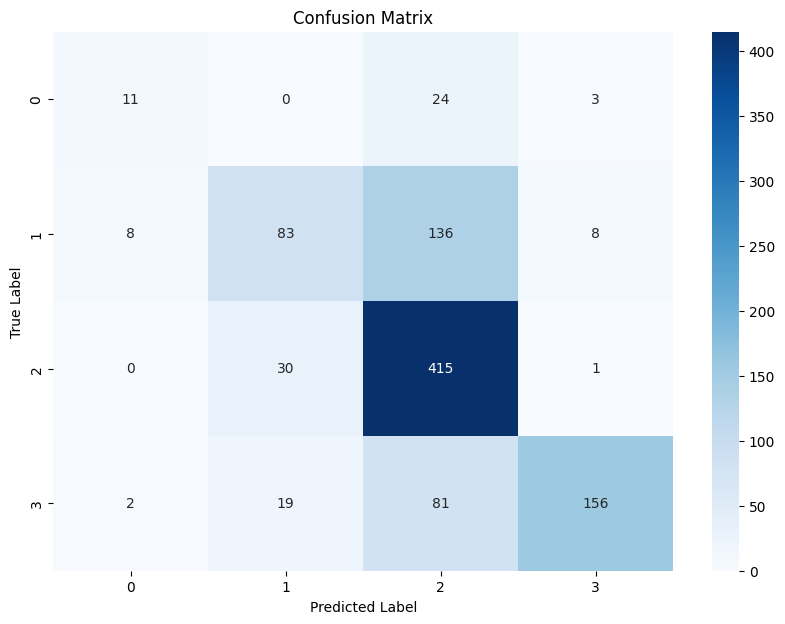

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 134 times. Predicted as: [2, 2, 2, 2, 3, 3, 2, 3, 0, 2, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 0, 3, 2, 0, 3, 3, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 0, 3, 2, 0, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 0, 0, 3, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2, 0, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 0]
Class 2 misclassified 120 times. Predicted as: [3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 0, 1, 1, 0, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 1, 3, 1, 0, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1]
Class 0 misclassified 41 times. Predicted as: [3, 1, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 3, 1, 1, 3, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 3, 3, 2, 1, 1, 1,

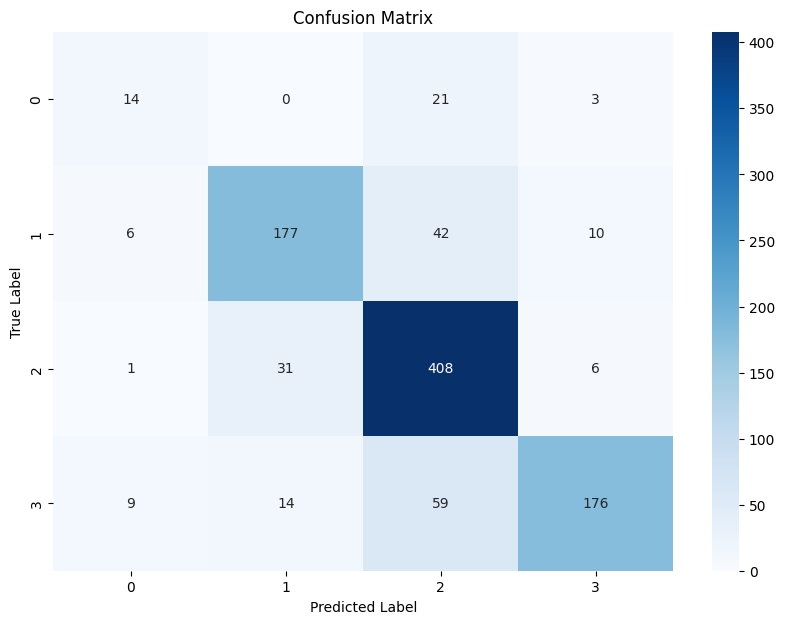

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 89 times. Predicted as: [3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 1]
Class 1 misclassified 121 times. Predicted as: [2, 0, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 3, 3, 0, 3, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 0, 2, 3, 0, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2]
Class 3 misclassified 73 times. Predicted as: [1, 2, 0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1]
Class 0 m

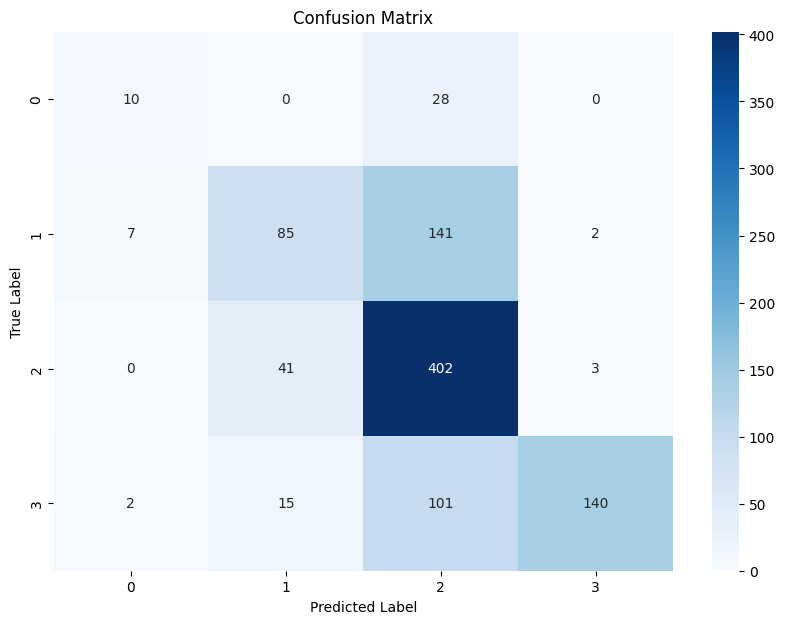

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 92 times. Predicted as: [1, 1, 3, 0, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3]
Class 3 misclassified 62 times. Predicted as: [1, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 0, 2]
Class 1 misclassified 106 times. Predicted as: [2, 2, 3, 2, 3, 0, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 3, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 0, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 0, 2]
Class 0 misclassified 31 times. Predicted as: [3, 1, 2, 2, 1, 2, 1, 3, 3, 1, 2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


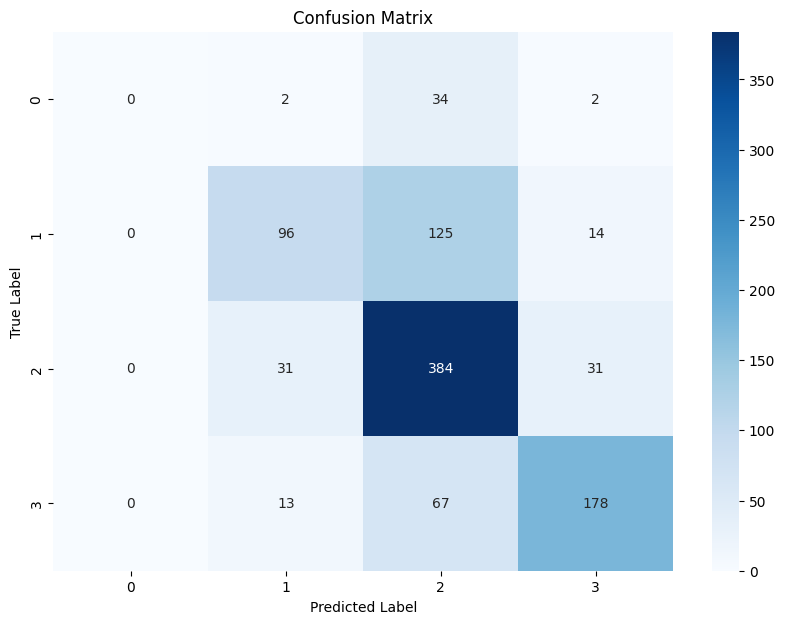

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 19 times. Predicted as: [2, 3, 3, 3, 3, 2, 1, 2, 3, 1, 2, 2, 3, 3, 2, 3, 3, 1, 1]
Class 2 misclassified 68 times. Predicted as: [1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 0, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1]
Class 3 misclassified 46 times. Predicted as: [1, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0]
Class 1 misclassified 70 times. Predicted as: [3, 2, 3, 0, 2, 3, 2, 3, 2, 3, 3, 2, 2, 0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2]
Epoch 23/100, Training Loss: 0.1460, Accuracy: 0.9479
F1 Score: 0.6298
Precision: 0.6539
Recall: 0.6141
Validation Loss: 2.4868, Accuracy: 0.6141
Class 1 misclassified 109 times. Predicted as: [2, 2, 2, 

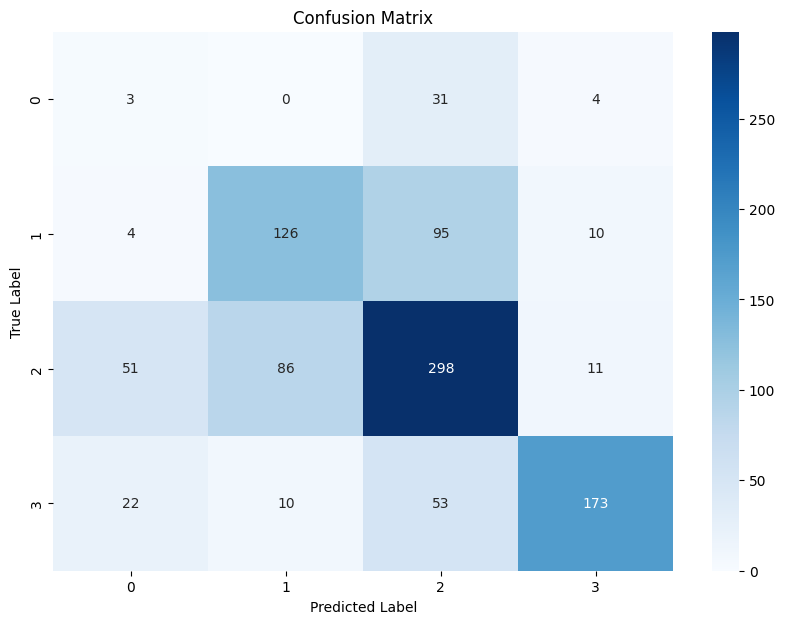

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 78 times. Predicted as: [2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 0, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 0, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2]
Class 2 misclassified 79 times. Predicted as: [1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3, 3]
Class 3 misclassified 73 times. Predicted as: [1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1]
Class 0 misclassified 24 times. Predicted as: [3, 2, 1, 3, 1, 1, 1, 3, 2, 1, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 1, 1, 2]
Epoch 24/100, Training Loss: 0.1708, Accuracy: 0.9

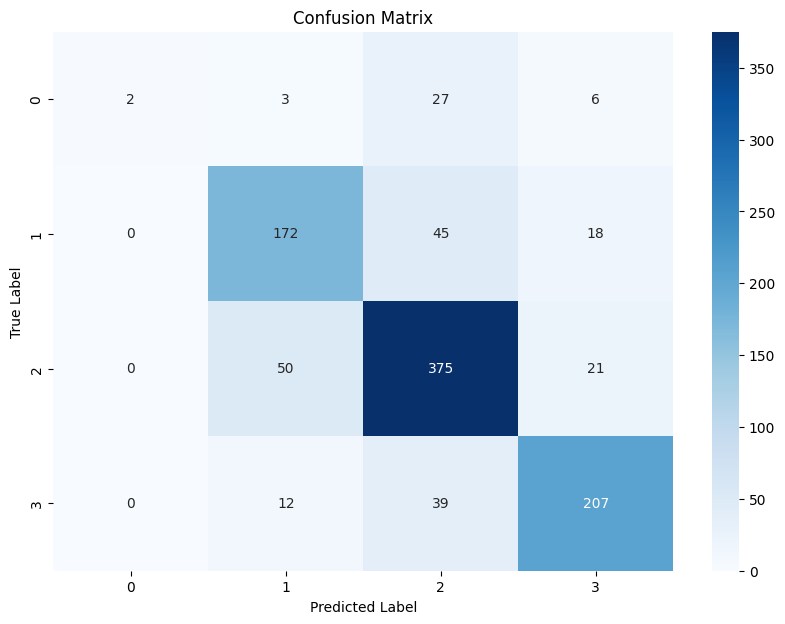

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 87 times. Predicted as: [2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 0, 2, 0, 2, 3, 2, 0, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 0, 3, 3, 3, 0, 0, 3, 3, 2, 3, 2, 2, 2]
Class 2 misclassified 77 times. Predicted as: [1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 0, 3, 1, 0, 3, 3, 3, 1, 3, 1, 1]
Class 0 misclassified 33 times. Predicted as: [3, 2, 1, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 3, 3, 3, 2, 1, 3, 3, 3, 1, 2, 2, 3, 3]
Class 3 misclassified 66 times. Predicted as: [2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1]
Epoch 25/100, Training 

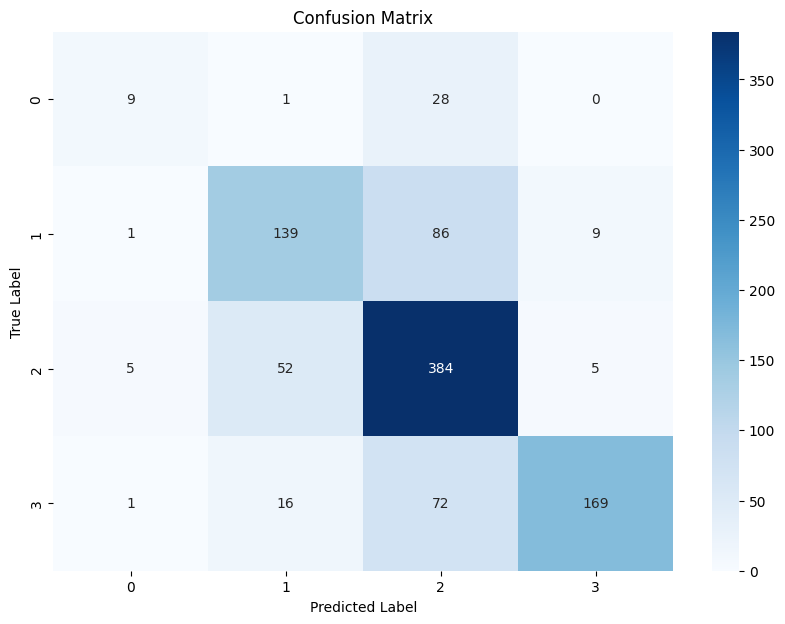

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 37 times. Predicted as: [1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2]
Class 2 misclassified 48 times. Predicted as: [1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 1]
Class 1 misclassified 53 times. Predicted as: [2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 0, 3, 0, 0, 3, 3, 3, 3, 2, 3, 0, 2, 2, 2, 0, 3, 2, 3, 3, 2, 2, 2, 3, 0, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2]
Class 0 misclassified 16 times. Predicted as: [2, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1]
Epoch 26/100, Training Loss: 0.1140, Accuracy: 0.9605
F1 Score: 0.6442
Precision: 0.6695
Recall: 0.6653
Validation Loss: 2.2366, Accuracy: 0.6653
Class 1 misclassified 142 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

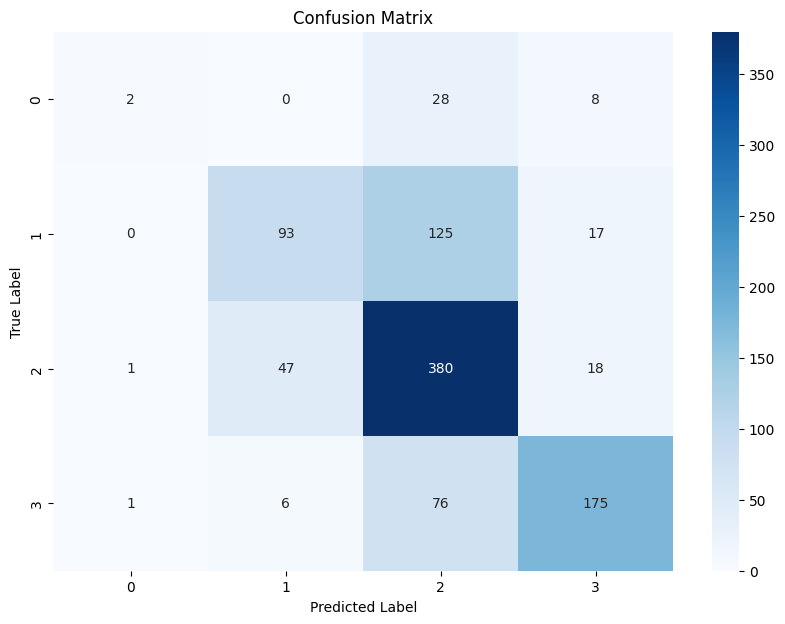

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 51 times. Predicted as: [3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1]
Class 3 misclassified 33 times. Predicted as: [2, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 1, 2]
Class 1 misclassified 52 times. Predicted as: [0, 3, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3]
Class 0 misclassified 14 times. Predicted as: [2, 2, 1, 3, 2, 1, 3, 1, 2, 2, 2, 3, 2, 1]
Epoch 27/100, Training Loss: 0.1063, Accuracy: 0.9615
F1 Score: 0.7790
Precision: 0.8014
Recall: 0.7840
Validation Loss: 1.0908, Accuracy: 0.7840
Class 1 misclassified 58 times. Predicted as: [2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2

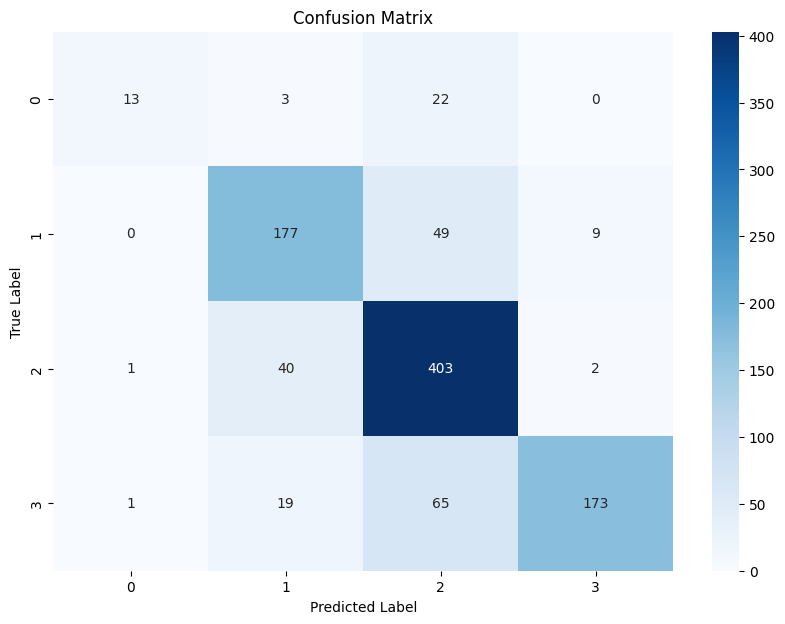

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 57 times. Predicted as: [3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 0, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 0, 2, 2, 2, 0, 2, 2, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2]
Class 3 misclassified 25 times. Predicted as: [1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 0]
Class 2 misclassified 50 times. Predicted as: [3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1]
Class 0 misclassified 12 times. Predicted as: [1, 2, 1, 3, 2, 1, 1, 1, 2, 1, 2, 1]
Epoch 28/100, Training Loss: 0.1028, Accuracy: 0.9630
F1 Score: 0.7005
Precision: 0.7013
Recall: 0.7011
Validation Loss: 1.3437, Accuracy: 0.7011
Class 3 misclassified 72 times. Predicted as: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0

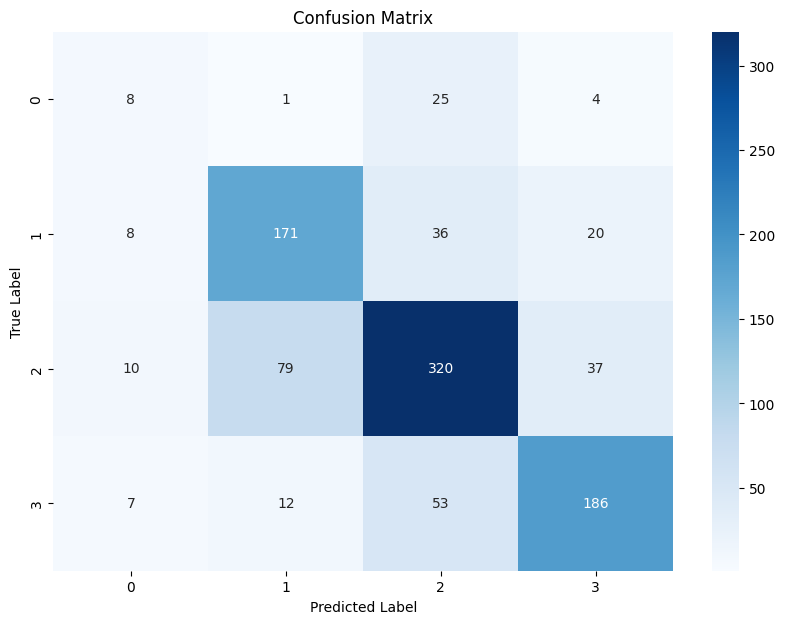

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 45 times. Predicted as: [3, 2, 3, 2, 0, 2, 0, 2, 2, 2, 0, 2, 3, 2, 3, 3, 2, 0, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 0, 2, 3, 2, 2, 0, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2]
Class 2 misclassified 43 times. Predicted as: [1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 3, 0, 1]
Class 3 misclassified 25 times. Predicted as: [2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1]
Class 0 misclassified 15 times. Predicted as: [3, 3, 3, 2, 2, 3, 1, 3, 1, 1, 2, 2, 2, 1, 2]
Epoch 29/100, Training Loss: 0.0975, Accuracy: 0.9671
F1 Score: 0.7525
Precision: 0.7812
Recall: 0.7615
Validation Loss: 1.2383, Accuracy: 0.7615
Class 1 misclassified 100 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 

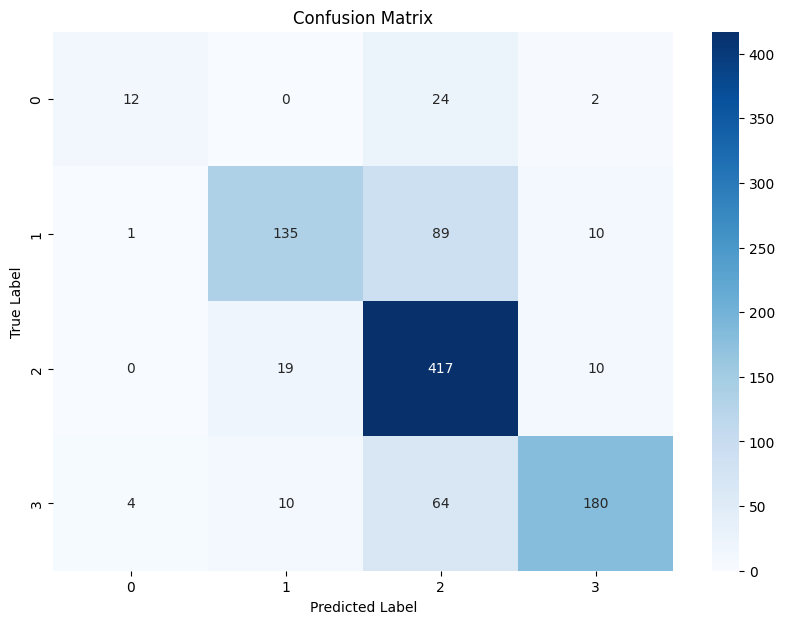

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 21 times. Predicted as: [2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 2, 2, 1, 3, 1, 2, 2, 2, 1, 1]
Class 2 misclassified 50 times. Predicted as: [1, 3, 3, 1, 1, 1, 0, 0, 0, 1, 3, 1, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Class 1 misclassified 45 times. Predicted as: [3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 0, 2, 2, 3, 2]
Class 3 misclassified 29 times. Predicted as: [0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 0]
Epoch 30/100, Training Loss: 0.1102, Accuracy: 0.9628
F1 Score: 0.6547
Precision: 0.6955
Recall: 0.6571
Validation Loss: 1.8718, Accuracy: 0.6571
Class 1 misclassified 129 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

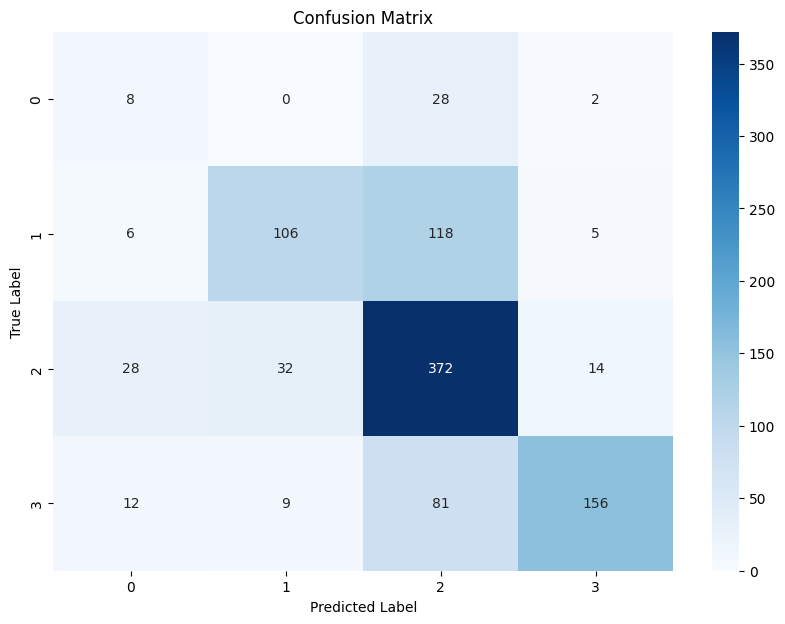

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 8 times. Predicted as: [2, 3, 1, 3, 3, 2, 3, 2]
Class 2 misclassified 54 times. Predicted as: [1, 1, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 3]
Class 3 misclassified 30 times. Predicted as: [1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]
Class 1 misclassified 42 times. Predicted as: [2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]
Epoch 31/100, Training Loss: 0.1020, Accuracy: 0.9656
F1 Score: 0.8007
Precision: 0.8250
Recall: 0.8086
Validation Loss: 0.8833, Accuracy: 0.8086
Class 1 misclassified 73 times. Predicted as: [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2]

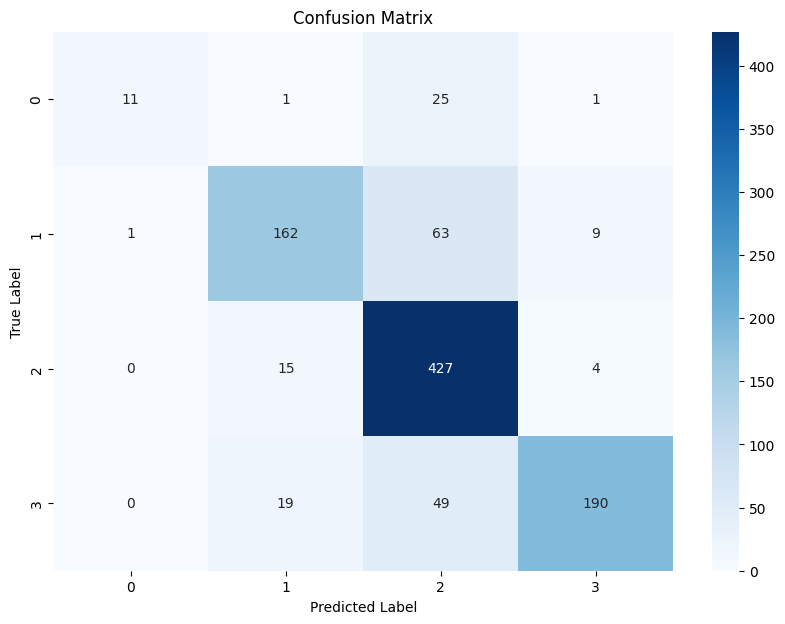

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 31 times. Predicted as: [2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2]
Class 2 misclassified 44 times. Predicted as: [3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Class 3 misclassified 25 times. Predicted as: [1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0]
Class 0 misclassified 4 times. Predicted as: [2, 1, 1, 2]
Epoch 32/100, Training Loss: 0.0742, Accuracy: 0.9733
F1 Score: 0.7592
Precision: 0.7704
Recall: 0.7656
Validation Loss: 1.4402, Accuracy: 0.7656
Class 1 misclassified 73 times. Predicted as: [2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 32 times. Predicted as: [3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 

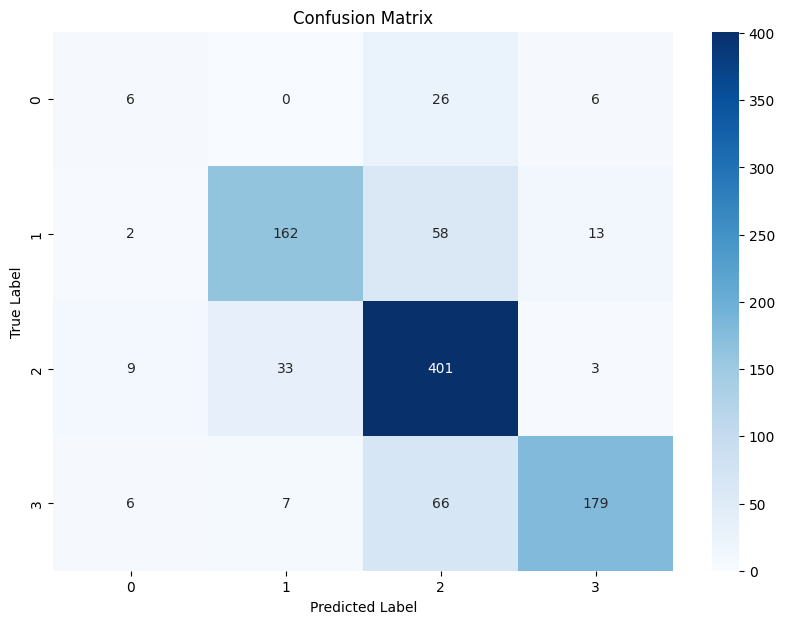

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 11 times. Predicted as: [3, 3, 3, 1, 3, 3, 1, 3, 2, 1, 2]
Class 2 misclassified 32 times. Predicted as: [0, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1]
Class 1 misclassified 27 times. Predicted as: [2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2]
Class 3 misclassified 33 times. Predicted as: [2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2]
Epoch 33/100, Training Loss: 0.0789, Accuracy: 0.9736
F1 Score: 0.6082
Precision: 0.6281
Recall: 0.6182
Validation Loss: 2.7703, Accuracy: 0.6182
Class 1 misclassified 150 times. Predicted as: [2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 

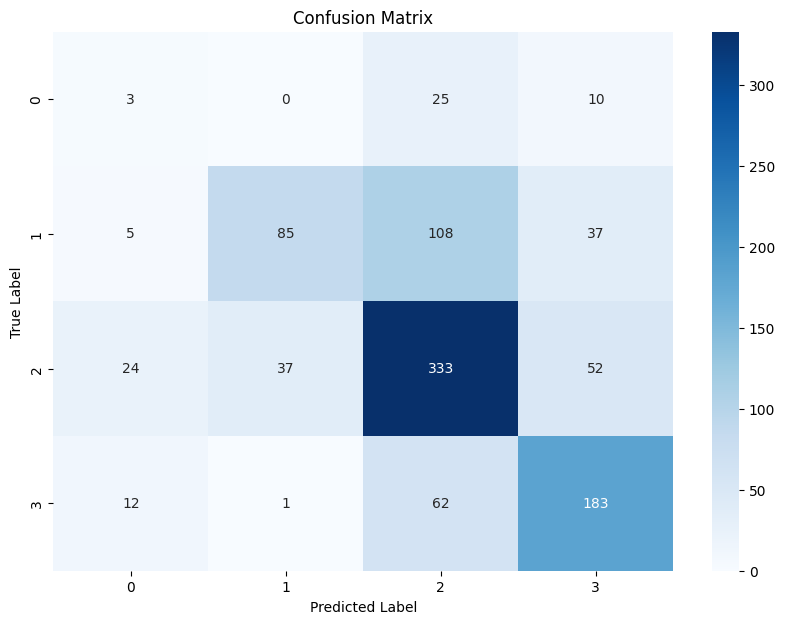

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 43 times. Predicted as: [3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 3, 3, 1, 3, 0, 1, 3]
Class 1 misclassified 49 times. Predicted as: [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 3, 0, 0, 3, 2, 2, 0, 2, 0, 2, 0, 3, 3, 0, 3, 3, 3, 3, 0, 2, 2, 2]
Class 3 misclassified 29 times. Predicted as: [2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 14 times. Predicted as: [2, 3, 2, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2]
Epoch 34/100, Training Loss: 0.0952, Accuracy: 0.9653
F1 Score: 0.6608
Precision: 0.6797
Recall: 0.6571
Validation Loss: 1.9455, Accuracy: 0.6571
Class 1 misclassified 96 times. Predicted as: [2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2

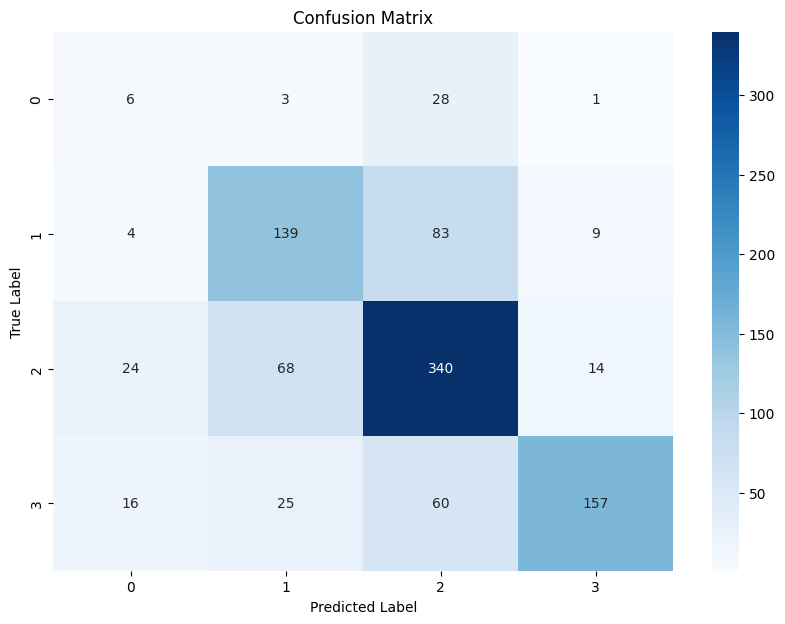

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 11 times. Predicted as: [2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2]
Class 1 misclassified 21 times. Predicted as: [2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 8 times. Predicted as: [3, 2, 2, 3, 2, 3, 1, 1]
Class 2 misclassified 26 times. Predicted as: [3, 1, 1, 0, 0, 1, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 1, 3, 3, 3, 1]
Epoch 35/100, Training Loss: 0.0538, Accuracy: 0.9831
F1 Score: 0.7528
Precision: 0.7820
Recall: 0.7595
Validation Loss: 1.6328, Accuracy: 0.7595
Class 1 misclassified 83 times. Predicted as: [2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]
Class 3 misclassified 95 times. Predicted as: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 

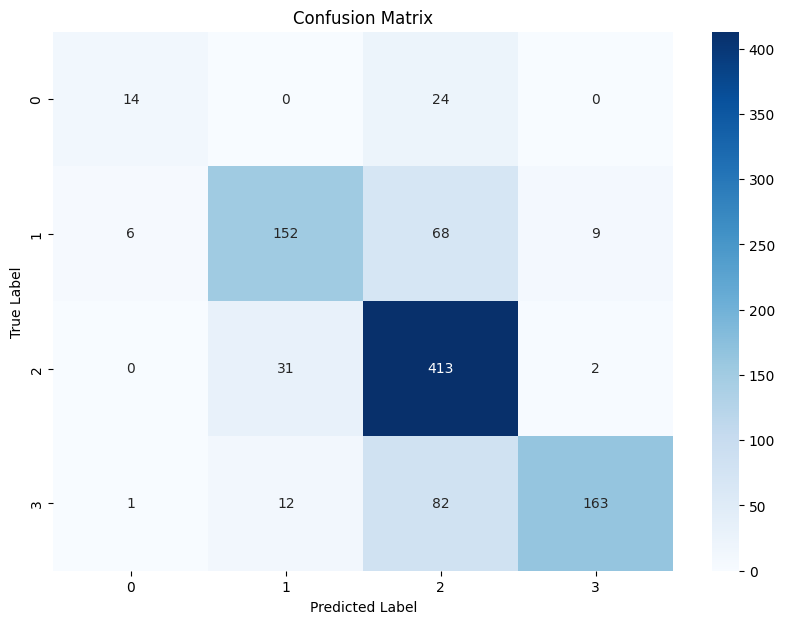

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 30 times. Predicted as: [3, 0, 3, 1, 1, 1, 3, 0, 1, 0, 1, 0, 0, 3, 1, 1, 0, 0, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1]
Class 3 misclassified 19 times. Predicted as: [1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2]
Class 1 misclassified 25 times. Predicted as: [3, 2, 3, 2, 0, 2, 2, 0, 0, 0, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2]
Class 0 misclassified 16 times. Predicted as: [2, 2, 2, 3, 1, 2, 2, 1, 1, 3, 3, 3, 3, 1, 2, 3]
Epoch 36/100, Training Loss: 0.0765, Accuracy: 0.9769
F1 Score: 0.6624
Precision: 0.7204
Recall: 0.6766
Validation Loss: 2.4583, Accuracy: 0.6766
Class 1 misclassified 105 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 34 times. P

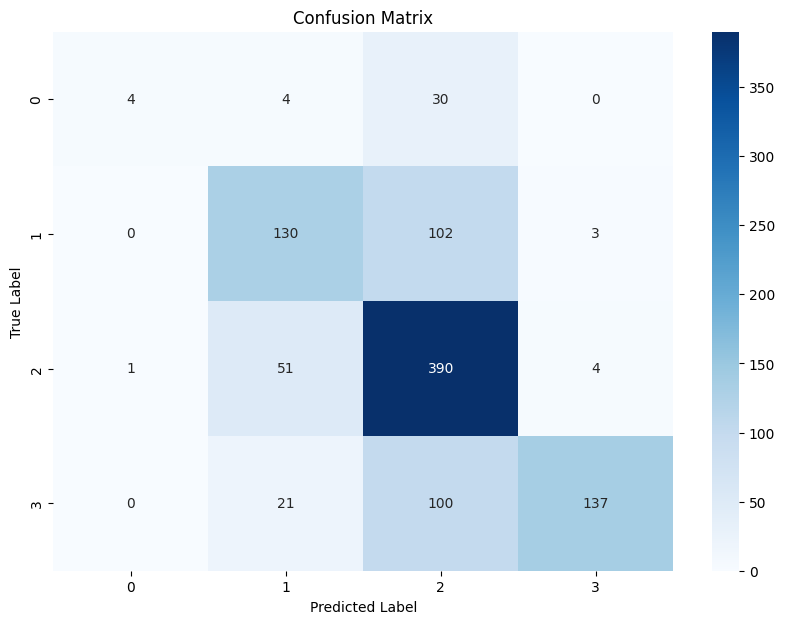

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 0 misclassified 10 times. Predicted as: [2, 3, 2, 3, 1, 1, 2, 1, 2, 2]
Class 2 misclassified 46 times. Predicted as: [1, 0, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 1, 3, 1]
Class 3 misclassified 23 times. Predicted as: [0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1]
Class 1 misclassified 39 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 0, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2]
Epoch 37/100, Training Loss: 0.1062, Accuracy: 0.9697
F1 Score: 0.7472
Precision: 0.7667
Recall: 0.7544
Validation Loss: 1.7012, Accuracy: 0.7544
Class 1 misclassified 94 times. Predicted as: [2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

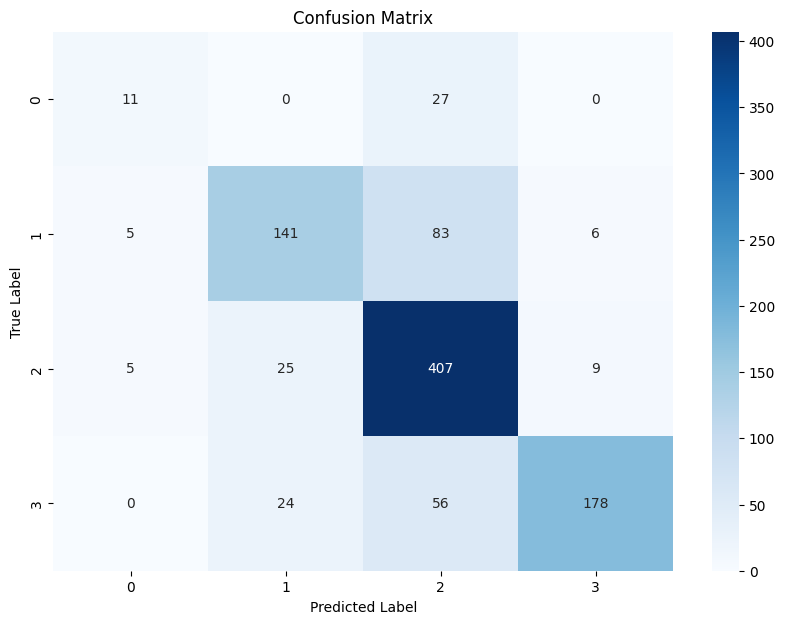

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 27 times. Predicted as: [3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1]
Class 1 misclassified 29 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 0, 3, 2, 2, 2]
Class 0 misclassified 3 times. Predicted as: [2, 2, 2]
Class 3 misclassified 13 times. Predicted as: [2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 0, 1]
Epoch 38/100, Training Loss: 0.0567, Accuracy: 0.9815
F1 Score: 0.8072
Precision: 0.8139
Recall: 0.8117
Validation Loss: 1.1172, Accuracy: 0.8117
Class 1 misclassified 59 times. Predicted as: [2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 0, 3, 0, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2]
Class 0 misclassified 25 times. Predicted as: [3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2]
Class 3 misclassified 63 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2

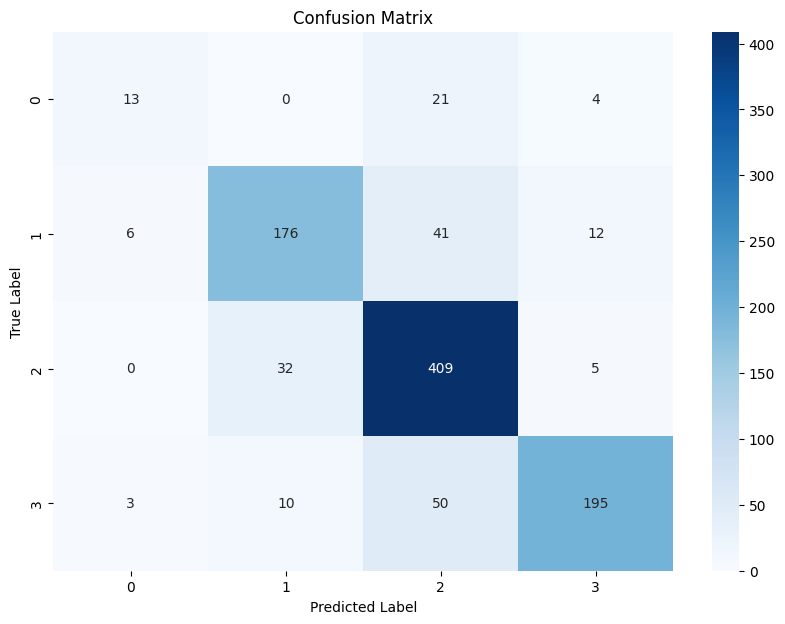

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 31 times. Predicted as: [1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 3, 0, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1]
Class 3 misclassified 17 times. Predicted as: [1, 2, 1, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2]
Class 1 misclassified 23 times. Predicted as: [2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2]
Class 0 misclassified 5 times. Predicted as: [2, 3, 3, 2, 2]
Epoch 39/100, Training Loss: 0.0601, Accuracy: 0.9805
F1 Score: 0.7972
Precision: 0.8035
Recall: 0.8004
Validation Loss: 1.0093, Accuracy: 0.8004
Class 1 misclassified 56 times. Predicted as: [2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 0, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2]
Class 0 misclassified 25 times. Predicted as: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2]
Class 2 misclassified 50 times. Predicted as: [1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1

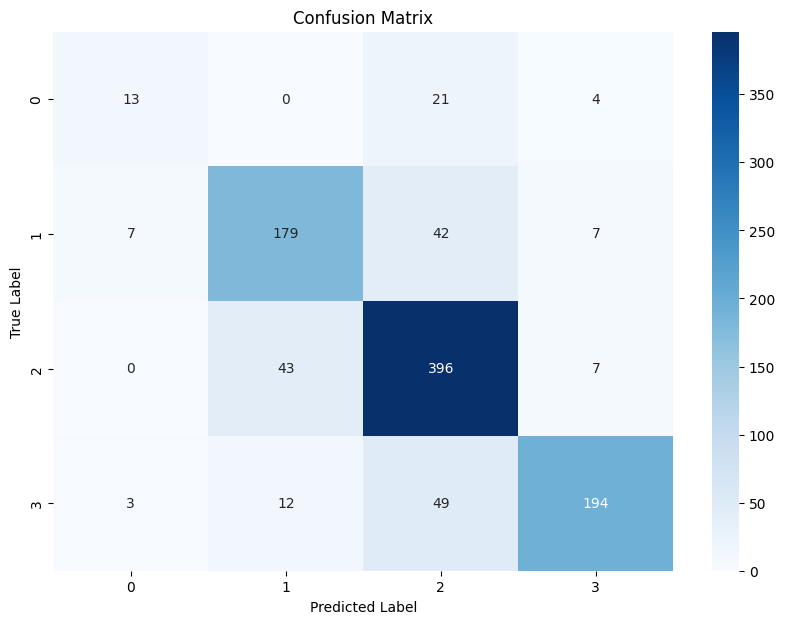

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 9 times. Predicted as: [2, 2, 2, 2, 0, 0, 3, 2, 2]
Class 2 misclassified 10 times. Predicted as: [1, 1, 3, 3, 3, 3, 1, 1, 3, 1]
Class 3 misclassified 6 times. Predicted as: [1, 2, 1, 2, 1, 0]
Class 0 misclassified 3 times. Predicted as: [1, 1, 1]
Epoch 40/100, Training Loss: 0.0248, Accuracy: 0.9928
F1 Score: 0.6565
Precision: 0.7001
Recall: 0.6704
Validation Loss: 3.1609, Accuracy: 0.6704
Class 1 misclassified 122 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2]
Class 0 misclassified 34 times. Predicted as: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Class 3 misclassified 

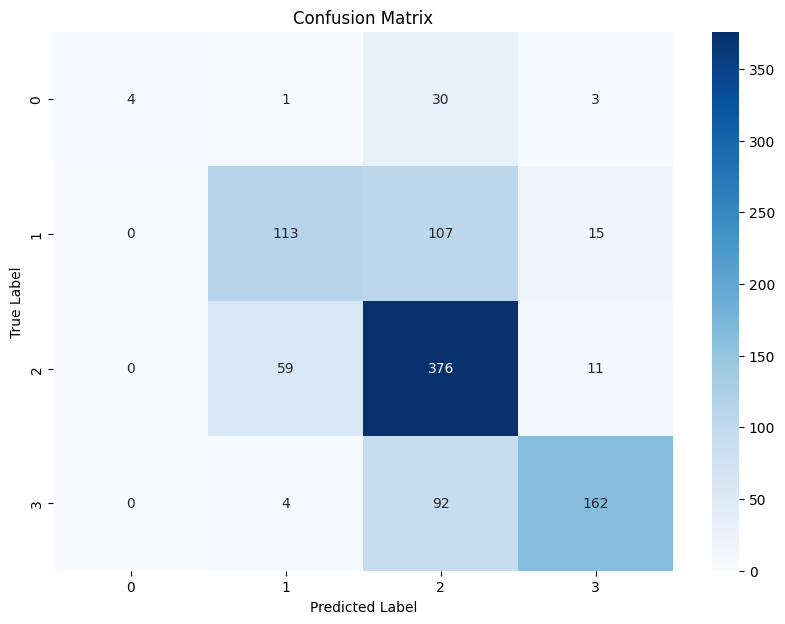

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 29 times. Predicted as: [3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3]
Class 3 misclassified 30 times. Predicted as: [0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2]
Class 1 misclassified 26 times. Predicted as: [2, 2, 2, 2, 3, 0, 0, 0, 0, 2, 3, 3, 3, 2, 3, 2, 2, 0, 2, 2, 2, 3, 3, 2, 3, 2]
Class 0 misclassified 15 times. Predicted as: [1, 1, 1, 2, 3, 1, 1, 2, 1, 3, 1, 3, 2, 3, 2]
Epoch 41/100, Training Loss: 0.0918, Accuracy: 0.9743
F1 Score: 0.7492
Precision: 0.7824
Recall: 0.7605
Validation Loss: 1.3678, Accuracy: 0.7605
Class 1 misclassified 107 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 

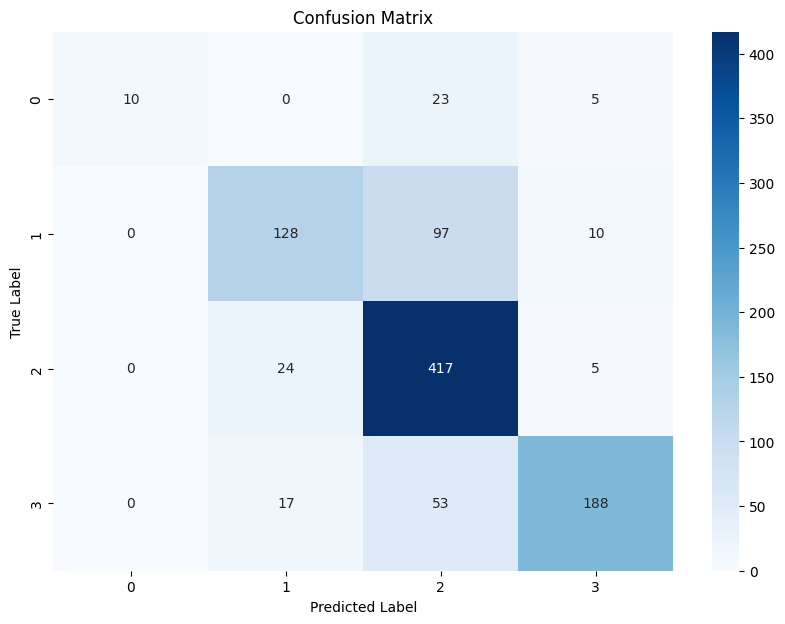

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 33 times. Predicted as: [1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1]
Class 1 misclassified 30 times. Predicted as: [2, 2, 0, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2]
Class 3 misclassified 24 times. Predicted as: [1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2]
Class 0 misclassified 10 times. Predicted as: [2, 1, 3, 3, 2, 2, 2, 3, 2, 2]
Epoch 42/100, Training Loss: 0.0750, Accuracy: 0.9751
F1 Score: 0.7990
Precision: 0.8033
Recall: 0.7963
Validation Loss: 0.8439, Accuracy: 0.7963
Class 1 misclassified 60 times. Predicted as: [2, 2, 2, 2, 3, 3, 3, 3, 2, 0, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 3, 2, 2, 2, 3, 0, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 0, 0, 0, 3, 2, 3, 2, 2]
Class 0 misclassified 22 times. Predicted as: [3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2]
Class 2 misclassified 65 times. Pre

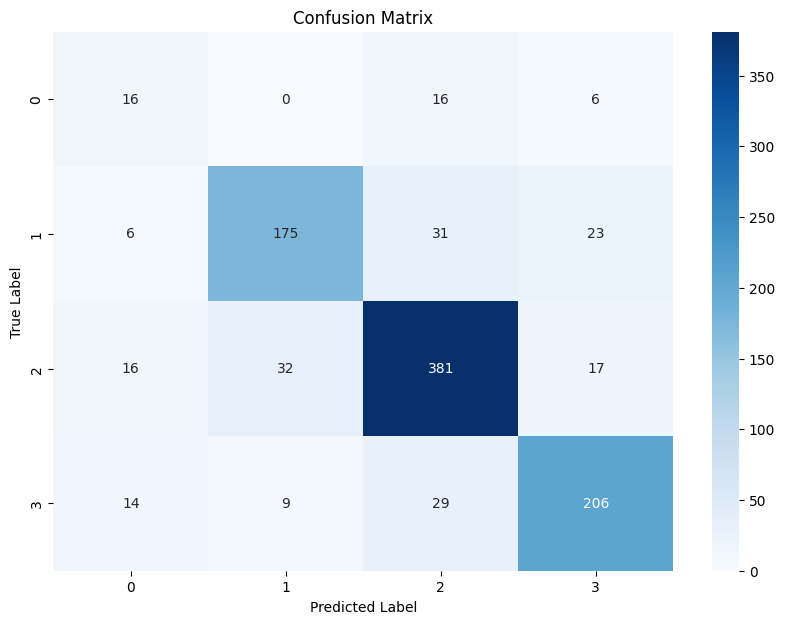

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 21 times. Predicted as: [0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1]
Class 0 misclassified 3 times. Predicted as: [3, 3, 2]
Class 3 misclassified 13 times. Predicted as: [2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1]
Class 1 misclassified 13 times. Predicted as: [2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3]
Epoch 43/100, Training Loss: 0.0398, Accuracy: 0.9872
F1 Score: 0.8370
Precision: 0.8495
Recall: 0.8393
Validation Loss: 0.8151, Accuracy: 0.8393
Class 1 misclassified 59 times. Predicted as: [2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 3, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3, 0, 2, 2, 2, 2]
Class 0 misclassified 14 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2]
Class 3 misclassified 67 times. Predicted as: [2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1

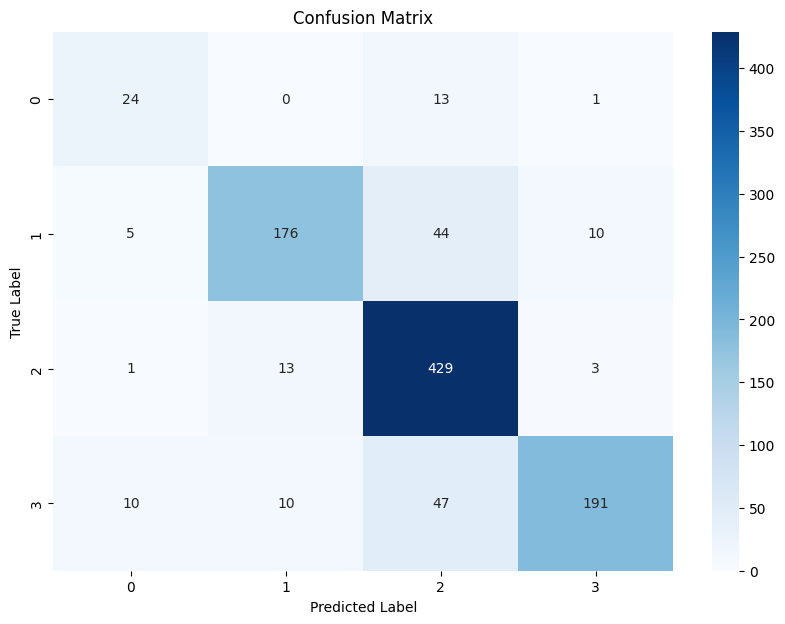

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 17 times. Predicted as: [2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 3, 2, 0, 2, 2, 2]
Class 3 misclassified 11 times. Predicted as: [2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2]
Class 2 misclassified 18 times. Predicted as: [3, 3, 0, 1, 3, 0, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1]
Class 0 misclassified 9 times. Predicted as: [2, 2, 2, 2, 1, 2, 1, 2, 2]
Epoch 44/100, Training Loss: 0.0474, Accuracy: 0.9859
F1 Score: 0.5875
Precision: 0.6513
Recall: 0.5476
Validation Loss: 4.0793, Accuracy: 0.5476
Class 1 misclassified 127 times. Predicted as: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 3, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 3, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 3, 2, 2, 3, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 0, 2, 2, 0, 3, 2, 0, 3, 2, 2, 0, 2, 0, 2, 0, 3, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2]
Class 3 misclassified 113 times. Predicted as: [2, 0, 0, 0, 0, 2, 2, 2, 0

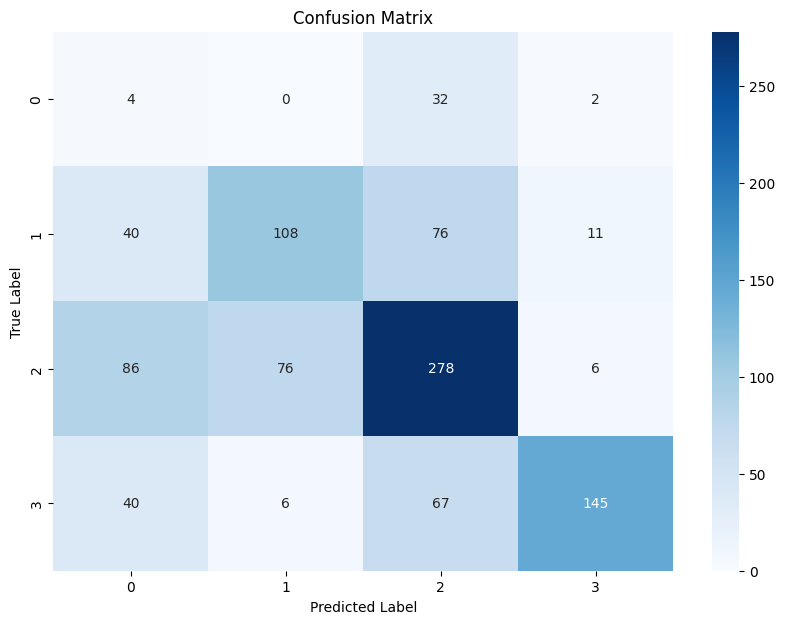

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 23 times. Predicted as: [3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2]
Class 2 misclassified 28 times. Predicted as: [1, 0, 1, 3, 1, 3, 1, 1, 3, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1]
Class 3 misclassified 15 times. Predicted as: [2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1]
Class 0 misclassified 2 times. Predicted as: [2, 1]
Epoch 45/100, Training Loss: 0.0616, Accuracy: 0.9825
F1 Score: 0.6621
Precision: 0.6882
Recall: 0.6438
Validation Loss: 2.7072, Accuracy: 0.6438
Class 1 misclassified 103 times. Predicted as: [3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 2, 3, 2, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2]
Class 0 misclassified 27 times. Predicted as: [3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,

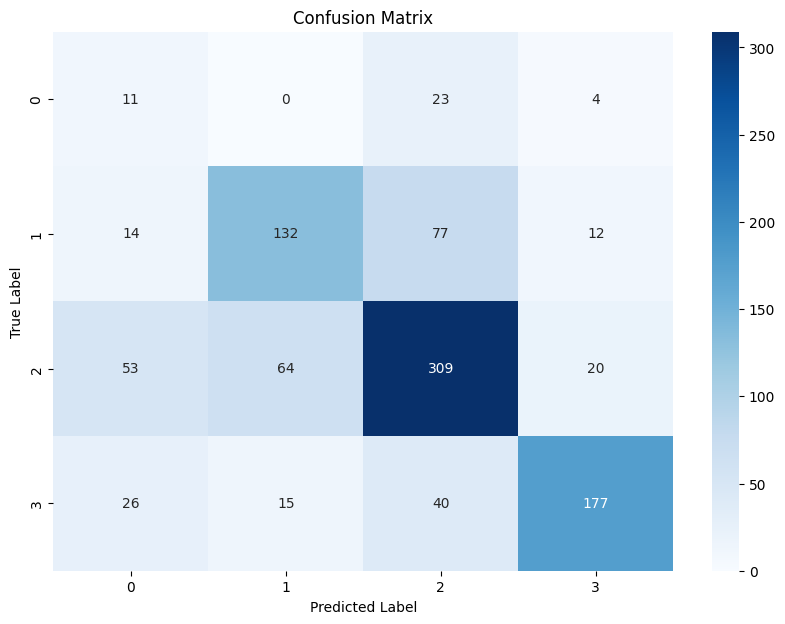

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 18 times. Predicted as: [3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1]
Class 1 misclassified 15 times. Predicted as: [2, 2, 2, 3, 2, 3, 2, 2, 0, 0, 3, 3, 2, 2, 2]
Class 3 misclassified 13 times. Predicted as: [2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1]
Class 0 misclassified 2 times. Predicted as: [1, 1]
Epoch 46/100, Training Loss: 0.0426, Accuracy: 0.9877
F1 Score: 0.6879
Precision: 0.7341
Recall: 0.7052
Validation Loss: 2.9928, Accuracy: 0.7052
Class 0 misclassified 29 times. Predicted as: [2, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Class 1 misclassified 142 times. Predicted as: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2,

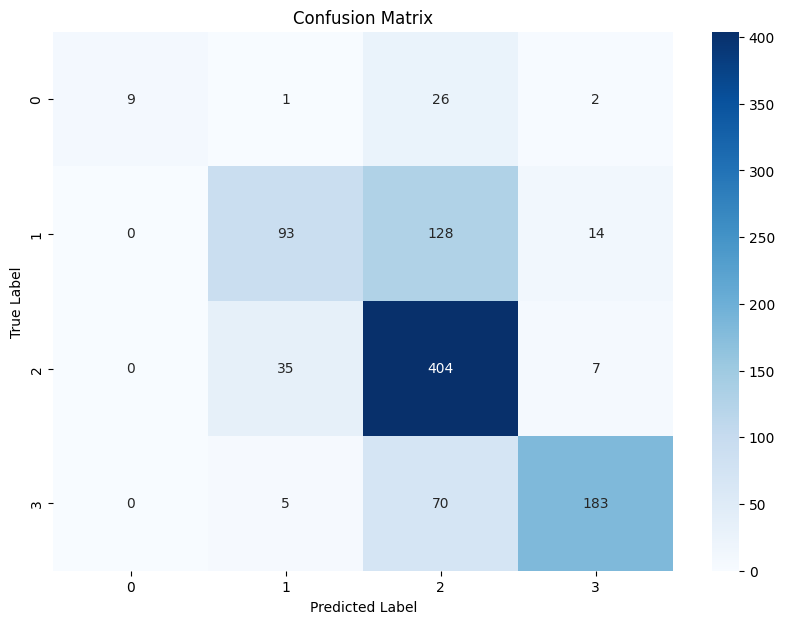

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 1 misclassified 33 times. Predicted as: [2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2]
Class 2 misclassified 33 times. Predicted as: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1]
Class 3 misclassified 10 times. Predicted as: [1, 1, 1, 2, 2, 2, 1, 0, 2, 2]
Class 0 misclassified 4 times. Predicted as: [2, 1, 1, 1]
Epoch 47/100, Training Loss: 0.0678, Accuracy: 0.9795
F1 Score: 0.8332
Precision: 0.8338
Recall: 0.8342
Validation Loss: 0.7257, Accuracy: 0.8342
Class 1 misclassified 41 times. Predicted as: [2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 0, 2]
Class 0 misclassified 19 times. Predicted as: [2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Class 2 misclassified 57 times. Predicted as: [3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1

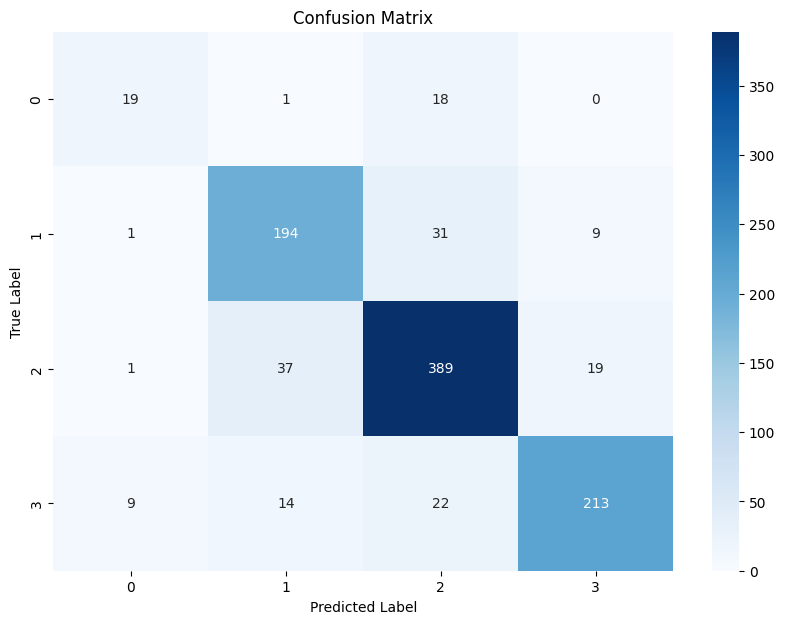

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 26 times. Predicted as: [2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 2, 2]
Class 2 misclassified 35 times. Predicted as: [3, 1, 0, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 3]
Class 1 misclassified 22 times. Predicted as: [3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 0, 2, 3, 3, 3, 3, 2, 2, 2, 2]
Class 0 misclassified 8 times. Predicted as: [2, 2, 2, 1, 3, 2, 3, 1]
Epoch 48/100, Training Loss: 0.0780, Accuracy: 0.9766
F1 Score: 0.7343
Precision: 0.7576
Recall: 0.7482
Validation Loss: 1.6108, Accuracy: 0.7482
Class 1 misclassified 111 times. Predicted as: [2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2]
Class 0 miscl

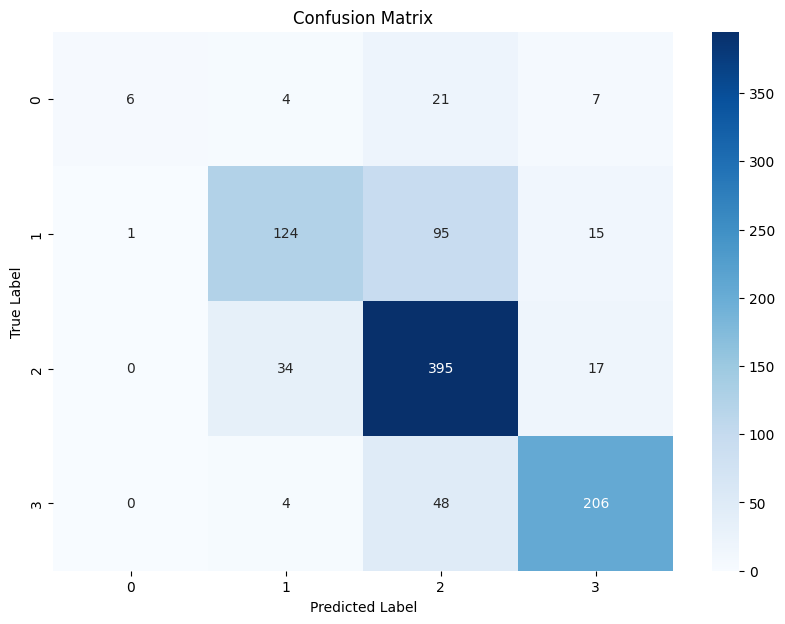

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 2 misclassified 11 times. Predicted as: [3, 3, 3, 1, 3, 1, 1, 1, 0, 3, 3]
Class 1 misclassified 5 times. Predicted as: [2, 2, 0, 2, 2]
Class 3 misclassified 8 times. Predicted as: [2, 2, 2, 0, 2, 2, 0, 2]
Class 0 misclassified 4 times. Predicted as: [3, 3, 3, 3]
Epoch 49/100, Training Loss: 0.0283, Accuracy: 0.9928
F1 Score: 0.8217
Precision: 0.8338
Recall: 0.8219
Validation Loss: 0.8544, Accuracy: 0.8219
Class 1 misclassified 43 times. Predicted as: [2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2, 2, 2]
Class 3 misclassified 77 times. Predicted as: [2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0]
Class 2 misclassified 38 times. Predicted as: [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 

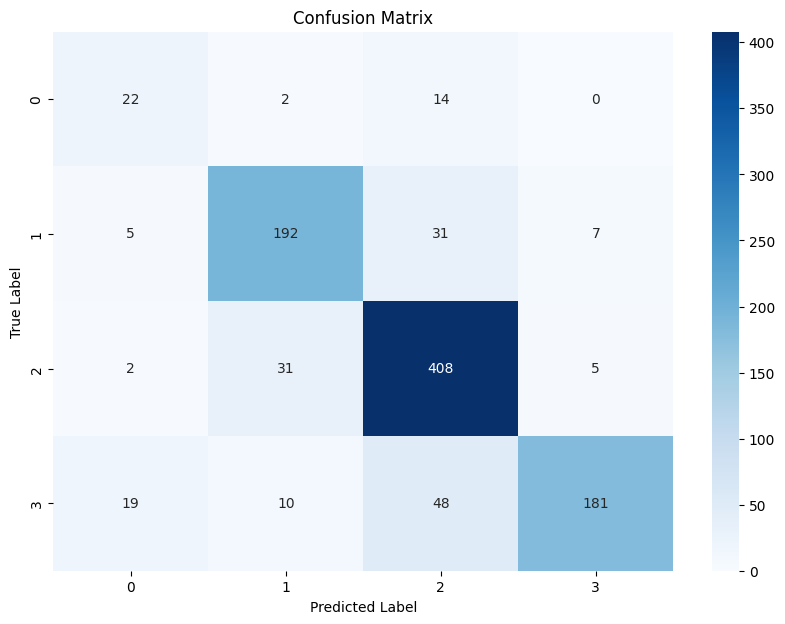

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Class 3 misclassified 11 times. Predicted as: [0, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1]
Class 2 misclassified 10 times. Predicted as: [1, 1, 3, 1, 1, 0, 3, 1, 1, 3]
Class 1 misclassified 5 times. Predicted as: [3, 2, 3, 3, 3]
Class 0 misclassified 3 times. Predicted as: [2, 2, 1]
Epoch 50/100, Training Loss: 0.0229, Accuracy: 0.9926
F1 Score: 0.8305
Precision: 0.8393
Recall: 0.8321
Validation Loss: 0.9034, Accuracy: 0.8321
Class 1 misclassified 54 times. Predicted as: [2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2, 3, 2, 0, 0, 0, 2, 2, 2, 2]
Class 3 misclassified 65 times. Predicted as: [2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0]
Class 2 misclassified 29 times. Predicted as: [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1,

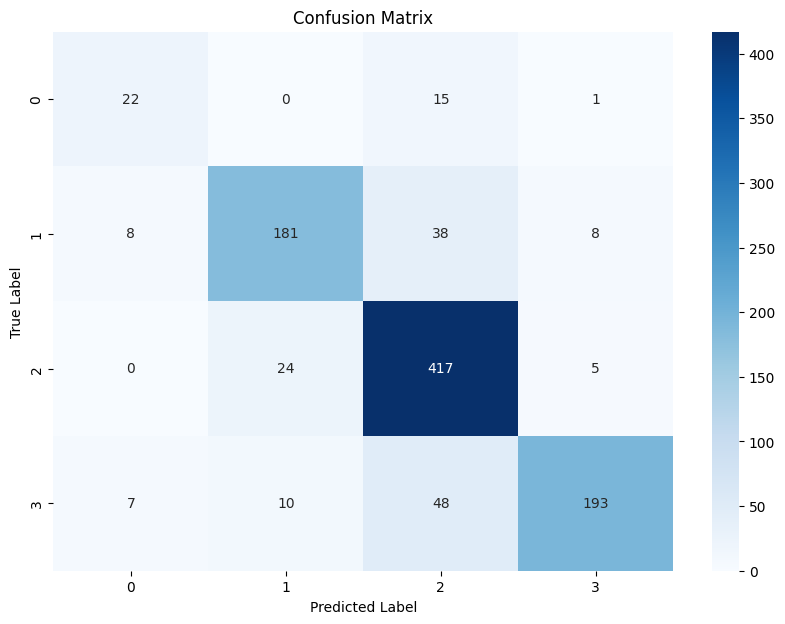

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, device=device, num_epochs=num_epochs)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Final Project/final_project_80_20.pth')

Losses plots

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses_training, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(num_epochs), losses_validation, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Accuracies Plots


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), accuracies_training, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.plot(range(num_epochs), accuracies_validation, marker='o', linestyle='-', color='r', label='Validation Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Function
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define the Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)
        target = output[0][target_class]
        target.backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activation[0].cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        cam = np.uint8(cam * 255)
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2], input_image.shape[3]), Image.ANTIALIAS)) / 255

        return cam

# Load the pre-trained model (example with ResNet18)
model.load_state_dict(torch.load('/content/drive/MyDrive/Final Project/final_project_80_20.pth'))

# Select the target layer
target_layer = model.resnet.layer4[1].conv2

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Define a transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to visualize CAM
def visualize_cam(cam, image, ax):
    image = image.permute(1, 2, 0).numpy()
    ax.imshow(image)
    ax.imshow(cam, cmap='jet', alpha=0.5)
    ax.axis('off')




In [ ]:
# Function to plot sample images with predictions and Grad-CAM heatmaps
def plot_sample_images_with_predictions(model, dataset, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, target = dataset[idx]
        image = image.unsqueeze(0).to(device) # Move image to the same device as the model
        with torch.no_grad():
            prediction = model(image).argmax(dim=1).item()


        cam = grad_cam.generate_cam(image, prediction)

        image = image.cpu().squeeze(0)

        if num_samples == 1:
            ax1, ax2 = axs
        else:
            ax1, ax2 = axs[i]

        ax1.imshow(image.permute(1, 2, 0).numpy())
        ax1.set_title(f'Prediction: {prediction}, Target: {target}')
        ax1.axis('off')

        visualize_cam(cam, image, ax2)
        ax2.set_title('Grad-CAM')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# model: your trained model
# dataset: instance of HER2Dataset
# device: 'cuda' if using GPU else 'cpu'
plot_sample_images_with_predictions(model, dataset_train, device)

##not used

In [ ]:
# import matplotlib.pyplot as plt

# # Mock data based on observation
# epochs_full = list(range(1, 201))
# train_acc_full = [0.91] * 200  # Example values
# val_acc_full = [
#     0.65, 0.63, 0.68, 0.60, 0.71, 0.68, 0.75, 0.60, 0.65, 0.55, 0.71, 0.64, 0.72, 0.67, 0.67, 0.70, 0.58, 0.60, 0.58, 0.60,
#     0.67, 0.60, 0.70, 0.65, 0.65, 0.58, 0.70, 0.61, 0.58, 0.61, 0.75, 0.63, 0.75, 0.66, 0.63, 0.65, 0.62, 0.62, 0.68, 0.71,
#     0.69, 0.69, 0.63, 0.63, 0.71, 0.64, 0.64, 0.64, 0.64, 0.67, 0.68, 0.61, 0.61, 0.63, 0.60, 0.62, 0.61, 0.65, 0.66, 0.62,
#     0.65, 0.66, 0.67, 0.66, 0.66, 0.67, 0.67, 0.67, 0.65, 0.66, 0.65, 0.65, 0.62, 0.65, 0.63, 0.63, 0.65, 0.61, 0.64, 0.64,
#     0.61, 0.65, 0.64, 0.62, 0.62, 0.67, 0.63, 0.63, 0.64, 0.64, 0.66, 0.65, 0.65, 0.67, 0.63, 0.66, 0.67, 0.65, 0.62, 0.62,
#     0.63, 0.61, 0.65, 0.65, 0.62, 0.64, 0.67, 0.62, 0.65, 0.66, 0.66, 0.64, 0.64, 0.65, 0.64, 0.66, 0.66, 0.67, 0.62, 0.67,
#     0.64, 0.63, 0.67, 0.63, 0.65, 0.63, 0.67, 0.64, 0.65, 0.63, 0.64, 0.63, 0.62, 0.67, 0.64, 0.67, 0.64, 0.67, 0.64, 0.66,
#     0.67, 0.66, 0.64, 0.63, 0.65, 0.67, 0.63, 0.62, 0.64, 0.67, 0.63, 0.65, 0.66, 0.64, 0.66, 0.66, 0.67, 0.63, 0.65, 0.64
# ]  # Example values

# epochs_100 = list(range(1, 101))
# train_acc_100 = [
#     0.5, 0.55, 0.58, 0.6, 0.62, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.71, 0.72, 0.73, 0.74, 0.75, 0.75, 0.76,
#     0.77, 0.77, 0.78, 0.79, 0.79, 0.8, 0.81, 0.81, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.87, 0.87,
#     0.88, 0.88, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91,
#     0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91,
#     0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91
# ]  # Example values
# val_acc_100 = [
#     0.55, 0.58, 0.6, 0.62, 0.63, 0.65, 0.67, 0.68, 0.69, 0.7, 0.72, 0.71, 0.73, 0.72, 0.74, 0.73, 0.75, 0.74, 0.76, 0.75,
#     0.77, 0.76, 0.78, 0.77, 0.79, 0.78, 0.8, 0.79, 0.81, 0.8, 0.82, 0.81, 0.83, 0.82, 0.84, 0.83, 0.85, 0.84, 0.86, 0.85,
#     0.87, 0.86, 0.88, 0.87, 0.89, 0.88, 0.9, 0.89, 0.91, 0.9, 0.92, 0.91, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91,
#     0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91,
#     0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91
# ]  # Example values

# # Plot the data
# plt.figure(figsize=(12, 6))
# plt.plot(epochs_full, train_acc_full, 'b-o', label='Training Accuracy (Full 200 Epochs)')
# plt.plot(epochs_full, val_acc_full, 'r-o', label='Validation Accuracy (Full 200 Epochs)')
# plt.plot(epochs_100, train_acc_100, 'b--x', label='Training Accuracy')
# plt.plot(epochs_100, val_acc_100, 'r--x', label='Validation Accuracy')


In [ ]:
# val_loader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

# def get_sample_predictions(num_samples, val_dataloader):
#   sample_images = []
#   sample_true_labels = []
#   sample_pred_labels = []
#   counter = 0
#   for ids, (inputs, targets) in enumerate(val_dataloader):
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = model(inputs)
#     image = Image.open(transforms.ToPILImage()(inputs[0])).convert('RGB')  # Load image and convert to RGB
#     sample_images.append(image.cpu().squeeze(0))
#     sample_true_labels.append(targets)
#     sample_pred_labels.append(outputs)
#     if counter == num_samples:
#       break
#     else:
#       counter += 1


#   return sample_images, sample_true_labels, sample_pred_labels


# def load_image(image_path):
#     image = Image.open(image_path).convert('RGB')  # Load image and convert to RGB
#     image = transform(image)  # Apply transformations
#     return image

# def get_sample_predictions(root_dir, model, n_iter, device):
#     model.eval()
#     sample_images = []
#     sample_true_labels = []  # This should be provided along with the image paths
#     sample_pred_labels = []
#     counter = 0
#     with torch.no_grad():
#         for image_path in os.listdir(root_dir):
#             image = load_image(root_dir + image_path)
#             input = image.to(device).unsqueeze(0)  # Add batch dimension and move to device
#             output = model(input)
#             pred_label = output.argmax(dim=1).item()

#             sample_images.append(image.cpu().squeeze(0))  # Move to CPU and remove batch dimension
#             sample_pred_labels.append(pred_label)
#             parts = image_path.split('_')
#             true_label = parts[2].split('.')[0][0]  # Remove the file extension and get the score
#             sample_true_labels.append(true_label)
#             counter +=1
#             if counter == n_iter:
#               break
#     return sample_images, sample_true_labels, sample_pred_labels

